# Evidence of horizontal gene transfer and environmental selection impacting antibiotic resistance evolution in soil-dwelling Listeria

In [1]:
# Initial imports
import glob
import os
from collections import OrderedDict, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shapefile
import skbio
import statsmodels.stats.multitest as smt
from mpl_toolkits.basemap import Basemap
from scipy import stats
from scipy.stats import ttest_rel
from statannot import add_stat_annotation
from scipy.stats import mannwhitneyu  
from scipy.stats import shapiro
from statsmodels.stats.multitest import multipletests

In [2]:
# Folder paths
out_path = "/projects/leaph/yingxian/AMR_Listeria/Data/Diversity_Analysis/Out/"
blast_sum_path = "/projects/leaph/yingxian/AMR_Listeria/Data/Gene_Detection/Out/"
card_path = "/projects/leaph/yingxian/AMR_Listeria/AMR_Listeria_add/CARD/Data/Out/"
shared = "/projects/leaph/shared/project_data/listeria_US/"
data_path = "/projects/leaph/yingxian/AMR_Listeria/Data/Diversity_Analysis/In/"

In [3]:
# prepare input data
env = pd.read_csv(shared + "environ_all.csv", index_col=0)
genome = pd.read_csv(shared + "Listeria_genomes.csv", index_col=0)
pd.merge(genome, env, how="left", left_on="Sample ID", right_index=True).to_csv(
    data_path + "genomes_env.csv"
)

## Fig. 1 | ARG profiles among soil-dwelling Listeria and their national distribution

### Fig. 1a Prevalence of ARGs across genomes

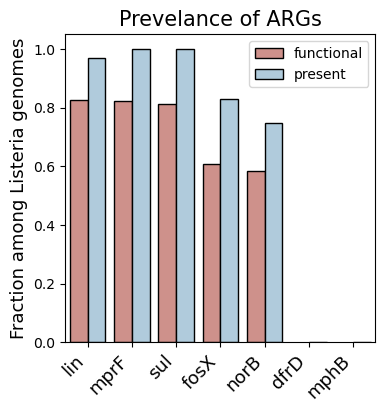

In [4]:
# Both ARG present and functional

plt.rcParams["figure.figsize"] = (4, 4)

df_functional = pd.read_csv(
    blast_sum_path + "ARG_functional_prop.csv", header=0, names=["gene", "proportion"]
)
df_functional = df_functional[df_functional["proportion"] != 0]
df_functional["group"] = "functional"

df_present = pd.read_csv(
    blast_sum_path + "ARG_present_prop.csv", header=0, names=["gene", "proportion"]
)
df_present = df_present[df_present["proportion"] != 0]
df_present["group"] = "present"

df_ARG = pd.concat([df_functional, df_present], axis=0)
df_ARG = df_ARG.replace("lmo0919", "lin")
df_ARG = df_ARG.replace("lmo1695", "mprF")

plt.rcParams["figure.figsize"] = (4, 4)

sns.barplot(
    data=df_ARG,
    x="gene",
    y="proportion",
    hue="group",
    palette=["#D98880", "#A9CCE3"],
    edgecolor="black",
)
plt.title("Prevelance of ARGs", size=15)
plt.legend(title="", loc="upper right")
plt.xticks(fontsize=13, rotation=45, ha="right")
plt.xlabel("")
plt.ylabel("Fraction among Listeria genomes", fontsize=13)
plt.savefig(out_path + "ARG_proportion.pdf", bbox_inches="tight", dpi=300)
plt.show()

### Fig. 1c Richness of ARGs in different Listeria species

In [5]:
plt.rcParams["figure.figsize"] = (8, 4)

genomes_env = pd.read_csv(data_path + "genomes_env.csv", index_col=0)

arg_functional = pd.read_csv(out_path + "ARG_functional_diversity.csv", index_col=0)
spe_functional = pd.merge(
    genomes_env[["Species"]],
    arg_functional,
    how="left",
    left_index=True,
    right_index=True,
)
spe_functional["group"] = "functional"
spe_functional = spe_functional.sort_values(["richness"], ascending=False)

arg_present = pd.read_csv(out_path + "ARG_present_diversity.csv", index_col=0)
spe_present = pd.merge(
    genomes_env[["Species"]], arg_present, how="left", left_index=True, right_index=True
)
spe_present["group"] = "present"
spe_present = spe_present.sort_values(["richness"], ascending=False)

spe_ARG = pd.concat([spe_functional, spe_present], axis=0)

spe_ARG = spe_ARG.groupby("Species").head(len(spe_ARG))

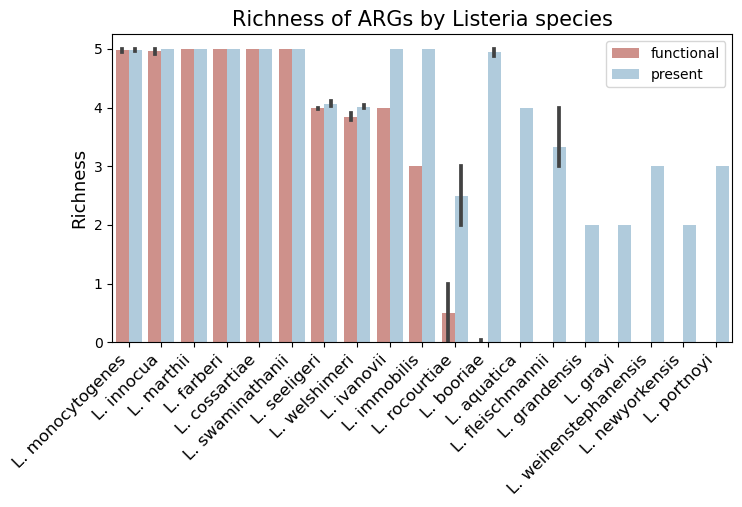

In [6]:
# Richness
sns.barplot(
    data=spe_ARG,
    x="Species",
    y="richness",
    hue="group",
    palette=["#D98880", "#A9CCE3"],
)
plt.xlabel("")
plt.ylabel("Richness", size=13)
plt.legend(title="")
plt.title("Richness of ARGs by Listeria species", size=15)
plt.xticks(rotation=45, ha="right", size=12)
plt.savefig(out_path + "ARG_richness_species.pdf", bbox_inches="tight", dpi=300)
plt.show()

### Fig. 1d Correlation between genetic similarity to L. monocytogenes and average richness of functional ARGs

In [7]:
# calculate pairwise ANI, then average the distance to all LM genomes, correlation analysis
anv = pd.read_csv(data_path + "ANIb_percentage_identity.tab", index_col=0, sep="\t")

# Turning the lower triangle to zeros and restacking to get the desired matrix
Anv_all = anv.where(np.triu(np.ones(anv.shape)).astype(bool))
Anv_all = Anv_all.stack().reset_index()
Anv_all.columns = ["Row", "Column", "Genetic Similarity"]

# Replacing the Isolate ID with the Species in Group1 and Group2
Species_df = genomes_env.reset_index().iloc[:, [0, 3]].copy()
# print(Species_df.head(10),'\n')

species_name = dict(zip(Species_df["Isolate ID"], Species_df["Species"]))
Anv_all["Species"] = Anv_all["Column"].replace(species_name)
Anv_all["Selected Species"] = Anv_all["Row"].replace(species_name)
Anv_all = Anv_all[["Species", "Selected Species", "Genetic Similarity"]]

# removing all L. monocytogenes from Group1 and  leaving only L. monocytogenes in Group2 for the mean
Anv_Lmono = Anv_all[Anv_all["Species"] != "L. monocytogenes"]
Anv_Lmono = Anv_Lmono[Anv_Lmono["Selected Species"] == "L. monocytogenes"]
average_values = pd.DataFrame(
    Anv_Lmono.groupby(["Species", "Selected Species"])["Genetic Similarity"].mean()
).reset_index()

average_values.to_csv('gen_sim.csv', index=False)

In [8]:
arg_div = pd.read_csv(out_path + "ARG_functional_diversity.csv", index_col=0)

arg_div_mod = arg_div.reset_index()

arg_div_mod["Species"] = arg_div_mod["id"].replace(species_name)
arg_div_mod = arg_div_mod[["Species", "shannon", "richness"]]

arg_div_mean = (
    arg_div_mod.groupby("Species")
    .agg({"shannon": "mean", "richness": "mean"})
    .reset_index()
)
arg_div_mean = arg_div_mean[arg_div_mean["Species"] != "L. monocytogenes"]

# Combining the Mean Correlation to arg_div mean Dataframe
arg_div_mean = pd.merge(
    arg_div_mean, average_values[["Species", "Genetic Similarity"]], on="Species"
)

0.8819585704837742 1.300596411220709e-06


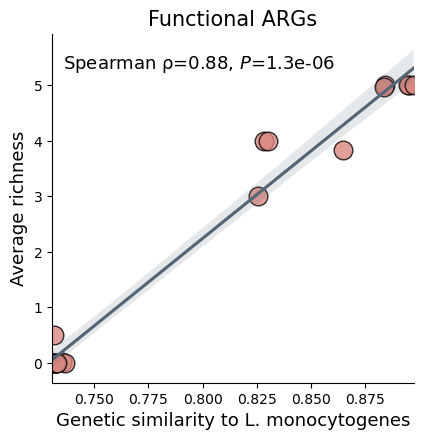

In [9]:
# Richness
rc = sns.lmplot(
    x="Genetic Similarity",
    y="richness",
    data=arg_div_mean,
    scatter_kws={"s": 180, "color": "#D98880", "edgecolor": "black"},
    line_kws={"color": "#566573"},
    legend=False,
    height=4.2,
    aspect=1.2,
)
rc.fig.suptitle("", size=15, fontweight="bold", style="italic")
r, p = stats.spearmanr(
    list(arg_div_mean["richness"]), list(arg_div_mean["Genetic Similarity"])
)
print(r, p)
g = plt.gca()
g.text(
    0.03,
    0.9,
    "Spearman ρ={:.2f}, $P$={:.2g}".format(r, p),
    transform=g.transAxes,
    fontsize=13,
    color="black",
)

rc.fig.set_size_inches(4, 4)

plt.xlabel("Genetic similarity to L. monocytogenes", size=13)
plt.ylabel("Average richness", size=13)
plt.title("Functional ARGs", size=15)

plt.savefig(
    out_path + "ARG_functional_richess_phylodistance_toLM.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

### Supplementary Fig. 1b Correlation between genetic similarity to L. monocytogenes and average richness of present ARGs

In [10]:
arg_div = pd.read_csv(out_path + "ARG_present_diversity.csv", index_col=0)

arg_div_mod = arg_div.reset_index()

arg_div_mod["Species"] = arg_div_mod["id"].replace(species_name)
arg_div_mod = arg_div_mod[["Species", "shannon", "richness"]]

arg_div_mean = (
    arg_div_mod.groupby("Species")
    .agg({"shannon": "mean", "richness": "mean"})
    .reset_index()
)
arg_div_mean = arg_div_mean[arg_div_mean["Species"] != "L. monocytogenes"]

# Combining the Mean Correlation to arg_div mean Dataframe
arg_div_mean = pd.merge(
    arg_div_mean, average_values[["Species", "Genetic Similarity"]], on="Species"
)

0.8827251979978658 1.2376351453364213e-06


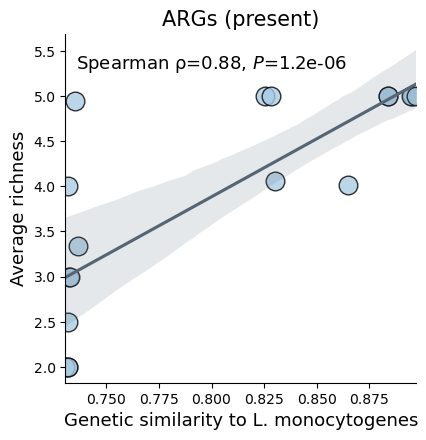

In [11]:
# Richness
rc = sns.lmplot(
    x="Genetic Similarity",
    y="richness",
    data=arg_div_mean,
    scatter_kws={"s": 180, "color": "#A9CCE3", "edgecolor": "black"},
    line_kws={"color": "#566573"},
    legend=False,
    height=4.2,
    aspect=1.2,
)
rc.fig.suptitle("", size=15, fontweight="bold", style="italic")
r, p = stats.spearmanr(
    list(arg_div_mean["richness"]), list(arg_div_mean["Genetic Similarity"])
)
print(r, p)
g = plt.gca()
g.text(
    0.03,
    0.9,
    "Spearman ρ={:.2f}, $P$={:.2g}".format(r, p),
    transform=g.transAxes,
    fontsize=13,
    color="black",
)

rc.fig.set_size_inches(4, 4)

plt.xlabel("Genetic similarity to L. monocytogenes", size=13)
plt.ylabel("Average richness", size=13)
plt.title("ARGs (present)", size=15)

plt.savefig(
    out_path + "ARG_present_richess_phylodistance_toLM.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

### Fig. 1b Proportion of functional ARGs

In [12]:
### function to get the proportion
def get_ARG_proportion(argMat, argSpec):
    argMat.set_index("id", inplace=True)
    argMat[argMat > 1] = 1
    argMat.reset_index(inplace=True)
    argSpec.rename(columns={"Isolate ID": "id"}, inplace=True)
    final_data = pd.merge(argMat, argSpec[["id", "Species"]], on=["id"], how="inner")
    print(argMat.shape, argSpec.shape, final_data.shape)
    req_cols = [_ for _ in final_data.columns if _ not in ["id", "Species"]]
    final_data_1 = final_data.groupby("Species", as_index=False)[req_cols].agg("mean")
    temp = final_data_1[req_cols].sum()
    keep_cols = temp[temp > 0].index
    final_data_1["Tot_sum"] = final_data_1[keep_cols].sum(axis=1)
    final_data_1.sort_values("Tot_sum", ascending=False, inplace=True)
    final_data_1.set_index("Species", inplace=True)
    final_data_2 = final_data_1[final_data_1.sum(axis=1) > 0]
    return final_data_2[keep_cols]

(594, 26) (594, 15) (594, 27)


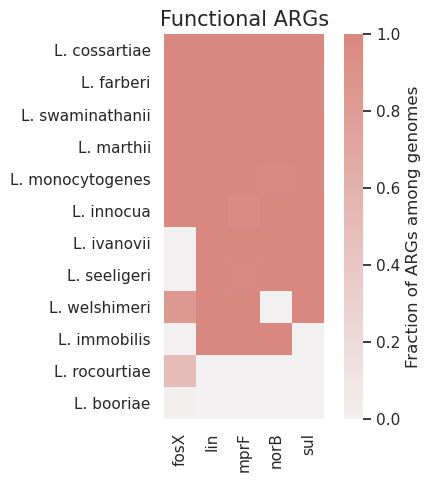

In [101]:
arg_mat_1 = pd.read_csv(blast_sum_path + "ARG_functional_matrix.csv")
arg_spec = pd.read_csv(shared + "/Listeria_genomes.csv")

data_1 = get_ARG_proportion(arg_mat_1, arg_spec)
data_1 = data_1.rename(columns={"lmo0919": "lin", "lmo1695": "mprF"})
## Heat map
sns.set(rc={"figure.figsize": (5, 5)})
my_palette = sns.light_palette("#D98880", as_cmap=True)
ax = sns.heatmap(
    data_1,
    cmap=my_palette,
    square=True,
    annot=False,
    fmt=".2f",
    annot_kws={"size": 5},
    cbar_kws={"label": "Fraction of ARGs among genomes"},
)
plt.title("Functional ARGs", fontsize=15)
ax.set(ylabel=None)
sns.diverging_palette(145, 300, s=60, as_cmap=True)
plt.savefig(
    out_path + "Heatmap_Fraction_Functional_ARG.pdf", bbox_inches="tight", dpi=600
)

### Supplementary Fig. 1a Proportion of present ARGs

(594, 26) (594, 15) (594, 27)


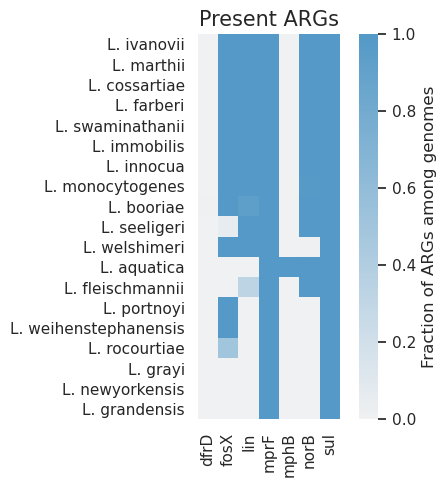

In [102]:
arg_mat_2 = pd.read_csv(blast_sum_path + "ARG_present_matrix.csv")
arg_spec = pd.read_csv(shared +"Listeria_genomes.csv")

data_2 = get_ARG_proportion(arg_mat_2, arg_spec)
data_2 = data_2.rename(columns={"lmo0919": "lin", "lmo1695": "mprF"})
## heat map2
sns.set(rc={"figure.figsize": (5, 5)})
my_palette = sns.light_palette("#5499C7", as_cmap=True)
ax = sns.heatmap(
    data_2,
    cmap=my_palette,
    square=True,
    annot=False,
    fmt=".2f",
    annot_kws={"size": 5},
    cbar_kws={"label": "Fraction of ARGs among genomes"},
)
plt.title("Present ARGs", fontsize=15)
ax.set(ylabel=None)
sns.diverging_palette(145, 300, s=60, as_cmap=True)
plt.savefig(out_path + "Heatmap_Fraction_ARG.pdf", bbox_inches="tight", dpi=600)

### Fig. 1e Spatial distribution of functional ARGs

In [15]:
from matplotlib.lines import Line2D


def gen_map(df, field, species_colors=None, min_marker_size=1):
    lats = df["Latitude"].tolist()
    lons = df["Longitude"].tolist()
    pos = df[field].tolist()
    species = df["Species"].tolist()
    zoom_scale = 3

    bbox = [
        np.min(lats) - zoom_scale,
        np.max(lats) + zoom_scale,
        np.min(lons) - zoom_scale,
        np.max(lons) + zoom_scale,
    ]

    fig, (ax, bx) = plt.subplots(
        2, 1, figsize=(18, 7), gridspec_kw={"height_ratios": [10, 3]}
    )

    m = Basemap(
        projection="merc",
        llcrnrlat=bbox[0],
        urcrnrlat=bbox[1],
        llcrnrlon=bbox[2],
        urcrnrlon=bbox[3],
        lat_ts=10,
        resolution="i",
        ax=ax,
    )

    m.drawcountries(linewidth=0.5, color="black")
    m.fillcontinents(color="#F8F9F9", lake_color="lightblue")

    m.drawparallels(np.arange(25, 55, 5), color="lightgray", labels=[1, 0, 0, 0])
    m.drawmeridians(
        np.arange(-125, -65, 5), color="lightgray", labels=[0, 0, 0, 1], rotation=45
    )
    m.drawmeridians(
        np.arange(-95, -92, 5),
        color="#21618C",
        labels=[0, 0, 1, 0],
        textcolor="#21618C",
        fontsize=13,
        linewidth=2,
    )
    m.drawmapboundary(fill_color="lightblue")

    handles = []
    labels = []
    sizes = []
    for lon, lat, po, sp in zip(lons, lats, pos, species):
        sizes.append((round(po, 1)))
        x, y = m(lon, lat)
        msize = po**min_marker_size + 5
        if msize > 5:
            if species_colors is not None and sp in species_colors:
                marker = m.plot(
                    x,
                    y,
                    "o",
                    markersize=msize,
                    color=species_colors[sp],
                    markeredgecolor="#212121",
                )
            else:
                marker = m.plot(
                    x,
                    y,
                    "o",
                    markersize=msize,
                    color="#A9CCE3",
                    markeredgecolor="#212121",
                )
        else:
            if species_colors is not None and sp in species_colors:
                marker = m.plot(x, y, "x", markersize=10, color=species_colors[sp])
            else:
                marker = m.plot(x, y, "x", markersize=10, color="grey")

        if marker:
            handles.append(marker[0])
            labels.append(sp)

    # Remove duplicates from labels
    unique_labels = list(set(labels))

    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            markersize=12,
            color="w",
            markerfacecolor=species_colors[label],
            markeredgecolor="#212121",
            label=label,
        )
        for label in unique_labels
    ]
    legend1 = ax.legend(
        handles=legend_elements,
        loc="upper left",
        bbox_to_anchor=(1.02, 0.9),
        ncol=2,
        title="Species Color",
    )
    ax.add_artist(legend1)

    sizes = sorted(list(set(sizes)))
    markers = [
        Line2D(
            [0],
            [0],
            marker="o",
            markersize=size * 2,
            color="w",
            markeredgecolor="black",
            label=str(size),
        )
        for size in sizes
    ]
    legend2 = bx.legend(
        handles=markers,
        loc="right",
        bbox_to_anchor=(0.9, 1.8),
        title="Marker Size",
        ncol=2,
    )
    bx.add_artist(legend2)

    # ax.axis('off')
    bx.axis("off")
    # plt.subplots_adjust(left=0.5)
    plt.tight_layout()

    return m

In [16]:
# Using Seaborn
import colorcet as cc

genomes_env = pd.read_csv(data_path + "genomes_env.csv", index_col=0)

import seaborn as sns

# Get the unique species names
unique_species = list(genomes_env["Species"].unique())
unique_species.reverse()


# Generate a color palette with the number of unique species
color_palette = sns.color_palette(cc.glasbey_light, n_colors=len(unique_species))

# Create a dictionary mapping species to colors
species_colors = dict(zip(unique_species, color_palette))

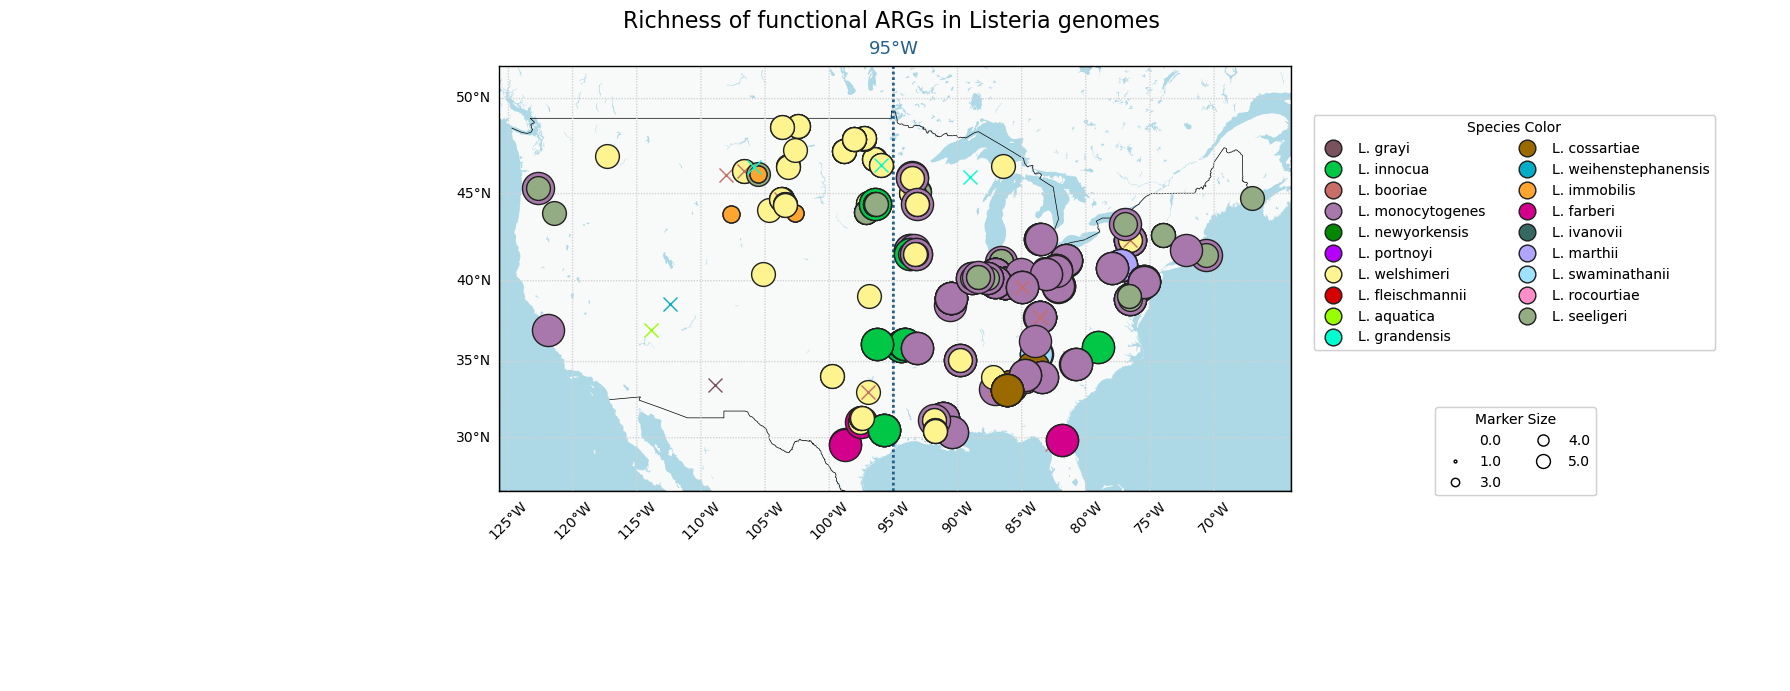

In [17]:
# functional ARGs
arg_div = pd.read_csv(out_path + "ARG_functional_diversity.csv", index_col=0)
div_loc = pd.merge(
    genomes_env[["Latitude", "Longitude", "Species"]],
    arg_div,
    how="left",
    left_index=True,
    right_index=True,
)


gen_map(div_loc, "richness", species_colors=species_colors, min_marker_size=1.8)
plt.suptitle("Richness of functional ARGs in Listeria genomes ", size=16)
plt.subplots_adjust(top=0.9)
plt.savefig(out_path + "functional_ARG_richness_map.pdf", dpi=500)
plt.show()

### Supplementary Fig. 1c Spatial distribution of present ARGs

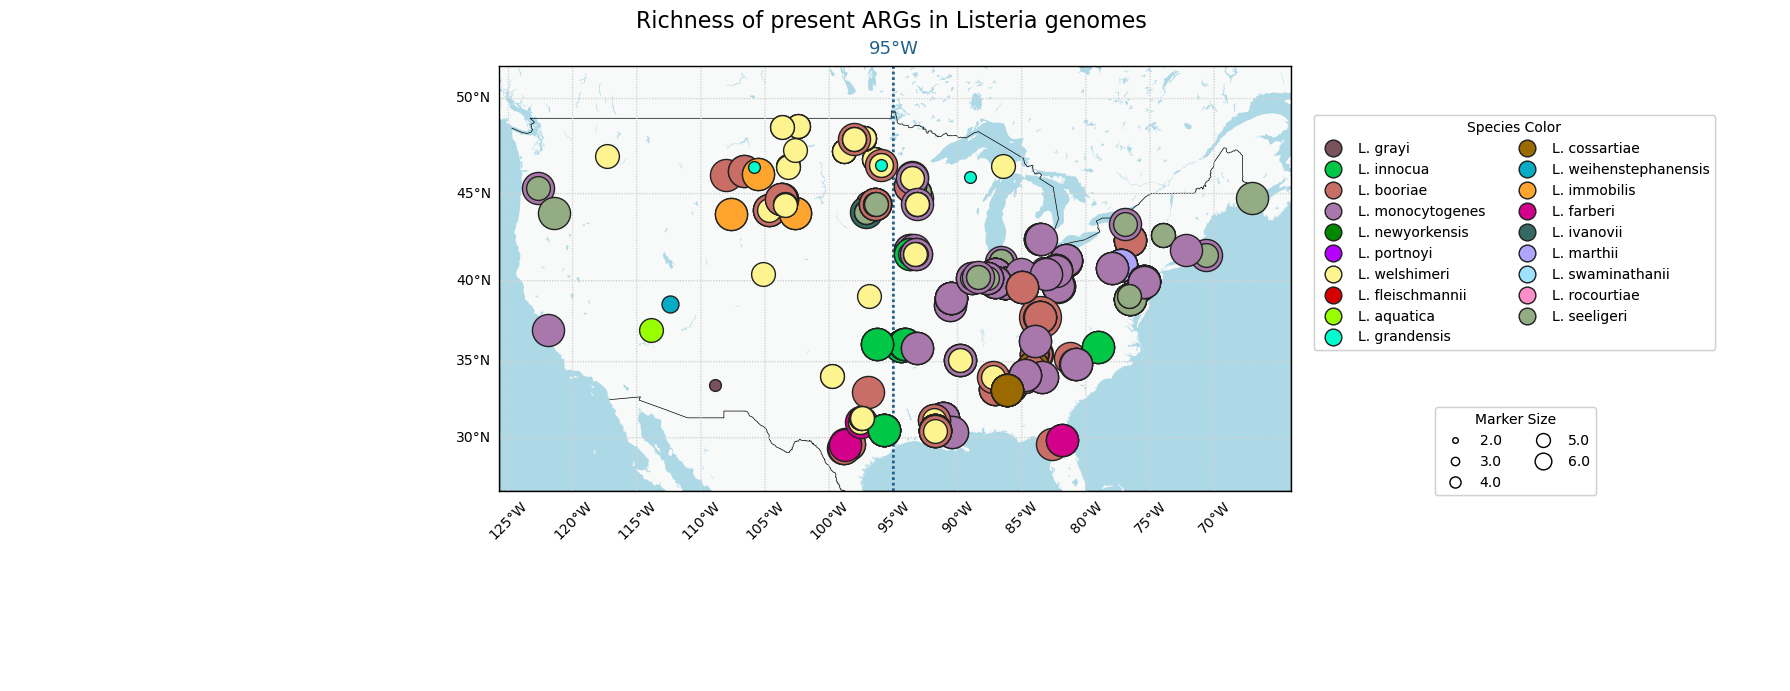

In [18]:
# present ARGs
arg_div = pd.read_csv(out_path + "ARG_present_diversity.csv", index_col=0)
div_loc = pd.merge(
    genomes_env[["Latitude", "Longitude", "Species"]],
    arg_div,
    how="left",
    left_index=True,
    right_index=True,
)


gen_map(div_loc, "richness", species_colors=species_colors, min_marker_size=1.8)
plt.suptitle("Richness of present ARGs in Listeria genomes ", size=16)
plt.subplots_adjust(top=0.9)
plt.savefig(out_path + "present_ARG_richness_map.pdf", dpi=500)
plt.show()

## Fig. 4 | Environmental conditions associated with ARG richness and genetic divergence

In [19]:
genomes_env = pd.read_csv(data_path + "genomes_env.csv", index_col=0)
average_values = pd.read_csv('gen_sim.csv')

# calculate pairwise ANI, then average the distance to all LM genomes, correlation analysis
anv = pd.read_csv(data_path + "ANIb_percentage_identity.tab", index_col=0, sep="\t")

# Turning the lower triangle to zeros and restacking to get the desired matrix
Anv_all = anv.where(np.triu(np.ones(anv.shape)).astype(bool))
Anv_all = Anv_all.stack().reset_index()
Anv_all.columns = ["Row", "Column", "Genetic Similarity"]

# Replacing the Isolate ID with the Species in Group1 and Group2
Species_df = genomes_env.reset_index().iloc[:, [0, 3]].copy()
# print(Species_df.head(10),'\n')

species_name = dict(zip(Species_df["Isolate ID"], Species_df["Species"]))
Anv_all["Species"] = Anv_all["Column"].replace(species_name)
Anv_all["Selected Species"] = Anv_all["Row"].replace(species_name)
Anv_all = Anv_all[["Species", "Selected Species", "Genetic Similarity"]]

# removing all L. monocytogenes from Group1 and  leaving only L. monocytogenes in Group2 for the mean
Anv_Lmono = Anv_all[Anv_all["Species"] != "L. monocytogenes"]
Anv_Lmono = Anv_Lmono[Anv_Lmono["Selected Species"] == "L. monocytogenes"]

average_values = pd.DataFrame(
    Anv_Lmono.groupby(["Species", "Selected Species"])["Genetic Similarity"].mean()
).reset_index()

In [20]:
# perform partial spearman corelation by controlling similarity to LM

from pingouin import partial_corr


def par_spearman(environment_merged_data, diversity):
    env_var_list = []
    corr_coeff_list = []
    p_value_list = []
    for i in environment_merged_data.iloc[:, 3:].columns:
        res = partial_corr(
            environment_merged_data,
            x=diversity,
            y=i,
            covar="Genetic Similarity",
            method="spearman",
        )
        env_var_list.append(i)
        corr_coeff_list.append(res["r"].values[0])
        p_value_list.append(res["p-val"].values[0])
    environment_corr_df = pd.DataFrame(
        {
            "Env_factor": env_var_list,
            "spearmanr_coefficient": corr_coeff_list,
            "pvalue": p_value_list,
        }
    )
    return environment_corr_df

### Fig. 4a Spearman's partial correlation between ARG richness in Listeria genomes and environmental variables

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


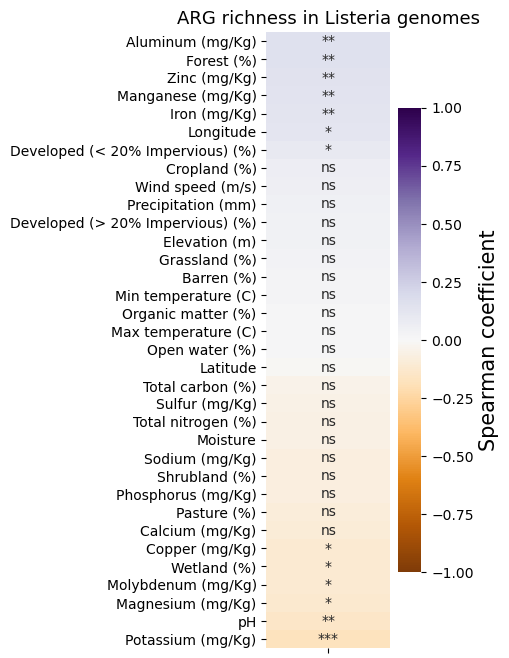

In [21]:
# prepare input data
env = pd.read_csv(shared + "environ_all.csv", index_col=0)
env = env.fillna(env.mean())
genome = pd.read_csv(shared + "Listeria_genomes.csv", index_col=0)
genome_id = genome[["Sample ID", "Species"]]

genome_id = genome_id.reset_index()
# get similairy of species to LM for each genome
genome_id_sim = pd.merge(
    genome_id, average_values, how="left", left_on="Species", right_on="Species"
)[["Isolate ID", "Sample ID", "Genetic Similarity"]]
# set LM genomes the similary to LM to 1
genome_id_sim = genome_id_sim.fillna(1)

genomes_env = pd.merge(
    genome_id_sim, env, how="left", left_on="Sample ID", right_index=True
).drop(columns=["Sample ID"])
genomes_env = genomes_env.set_index("Isolate ID")
arg_div = (
    pd.read_csv(out_path + "ARG_functional_diversity.csv", index_col=0)
    .sort_index()
    .rename_axis("Isolate ID")
)

arg_env = pd.merge(arg_div, genomes_env, left_index=True, right_index=True)

# perform spearman correlation between ARGs richness and environmental variables for genomes
environment_corr_df = par_spearman(arg_env, "richness")

environment_corr_df.reset_index(inplace=True)
environment_corr_df.rename(columns={"index": "Id"}, inplace=True)
environment_corr_df
environment_corr_df.sort_values(by="pvalue", inplace=True, ascending=True)
environment_corr_df["fdr_adjusted_pvalue"] = stats.false_discovery_control(
    environment_corr_df.pvalue
)
environment_corr_df.sort_values(by="Id", inplace=True)

conditions = [
    environment_corr_df["fdr_adjusted_pvalue"] < 0.0001,
    environment_corr_df["fdr_adjusted_pvalue"] < 0.001,
    environment_corr_df["fdr_adjusted_pvalue"] < 0.01,
    environment_corr_df["fdr_adjusted_pvalue"] < 0.05,
    environment_corr_df["fdr_adjusted_pvalue"] >= 0.05,
]
choices = ["****", "***", "**", "*", "ns"]
environment_corr_df["asterisk"] = np.select(conditions, choices, default=0)

environment_corr_df.sort_values("spearmanr_coefficient", ascending=False, inplace=True)
environment_corr_df

table = pd.pivot_table(
    environment_corr_df,
    values="spearmanr_coefficient",
    index=["Env_factor"],
    columns=[],
    aggfunc="mean",
)
table = table.sort_values("spearmanr_coefficient", ascending=False)
x = environment_corr_df["asterisk"].values
x = np.array(x).reshape(1, -1)

plt.rcParams["figure.figsize"] = (2, 8)
fig, ax = plt.subplots()
sns.heatmap(
    table[["spearmanr_coefficient"]],
    annot=x.T,
    vmin=-1,
    vmax=1,
    fmt="",
    cmap="PuOr",
    cbar_kws={"label": "Spearman coefficient"},
    ax=ax,
)
ax.figure.axes[-1].yaxis.label.set_size(15)
yticks = ax.get_yticklabels()
plt.ylabel("")
ax.set_title("ARG richness in Listeria genomes", fontsize=13)
# Remove the x-axis tick labels
ax.set_xticklabels("")
plt.savefig(out_path + "ARG_richness_env_cor.pdf", bbox_inches="tight", dpi=300)
plt.show()

### Fig. 4b VPA of the richness of functional

In [22]:
# Loading required packages
# Use this command if using online ipykernels like colab
# !pip install rpy2==3.5.1
# !pip install geopy - to install geopy
# !pip install mpu - to install mpu

import os

import geopy.distance
import matplotlib.pyplot as plt
import mpu
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr
from statsmodels.stats.multitest import fdrcorrection

# Preparing the input data
df_env = pd.read_csv(
    "/projects/leaph/yingxian/AMR_Listeria/Data/Diversity_Analysis/In/genomes_env.csv",
    index_col=0,
)
df_rich = pd.read_csv(
    "/projects/leaph/yingxian/AMR_Listeria/Data/Diversity_Analysis/Out/ARG_functional_diversity.csv"
)

# Fill all the empty fields of the climate variables with their respective median values
df_env["Precipitation (mm)"] = df_env["Precipitation (mm)"].fillna(
    df_env["Precipitation (mm)"].median()
)
df_env["Max temperature (C)"] = df_env["Max temperature (C)"].fillna(
    df_env["Max temperature (C)"].median()
)
df_env["Min temperature (C)"] = df_env["Min temperature (C)"].fillna(
    df_env["Min temperature (C)"].median()
)
df_env["Wind speed (m/s)"] = df_env["Wind speed (m/s)"].fillna(
    df_env["Wind speed (m/s)"].median()
)
# Merging environmental parameters and ARG richness
df_env_rich = pd.merge(
    df_env,
    df_rich,
    left_on=["Isolate ID"],
    right_on=["id"],
    how="inner",
)

In [23]:
# Computing genetic dissimilarity for controlling the confounding effect in later anaysis

genomes_env = pd.read_csv(
    "/projects/leaph/yingxian/AMR_Listeria/Data/Diversity_Analysis/In/genomes_env.csv",
    index_col=0,
)

# calculate pairwise ANI, then average the distance to all LM genomes, correlation analysis
anv = pd.read_csv(
    "/projects/leaph/yingxian/AMR_Listeria/Data/Diversity_Analysis/In/ANIb_percentage_identity.tab",
    index_col=0,
    sep="\t",
)

# Turning the lower triangle to zeros and restacking to get the desired matrix
Anv_all = anv.where(np.triu(np.ones(anv.shape)).astype(bool))
Anv_all = Anv_all.stack().reset_index()
Anv_all.columns = ["Row", "Column", "Genetic Similarity"]

# Replacing the Isolate ID with the Species in Group1 and Group2
Species_df = genomes_env.reset_index().iloc[:, [0, 3]].copy()
# print(Species_df.head(10),'\n')

species_name = dict(zip(Species_df["Isolate ID"], Species_df["Species"]))
Anv_all["Species"] = Anv_all["Column"].replace(species_name)
Anv_all["Selected Species"] = Anv_all["Row"].replace(species_name)
Anv_all = Anv_all[["Species", "Selected Species", "Genetic Similarity"]]

# removing all L. monocytogenes from Group1 and  leaving only L. monocytogenes in Group2 for the mean
Anv_Lmono = Anv_all[Anv_all["Species"] != "L. monocytogenes"]
Anv_Lmono = Anv_Lmono[Anv_Lmono["Selected Species"] == "L. monocytogenes"]
average_values = pd.DataFrame(
    Anv_Lmono.groupby(["Species", "Selected Species"])["Genetic Similarity"].mean()
).reset_index()

In [24]:


# Merging the calculated genetic dissimilarity (to LM) to their respective strain

df_env_rich_sim = pd.merge(df_env_rich, average_values, how="inner", left_on="Species", right_on="Species")

# set LM genomes the similary to LM to 1
df_env_rich_sim = df_env_rich_sim.fillna(1)

# List of columns you want to select
selected_columns = [
    "id",
    "Genetic Similarity",
    "richness",
    "Latitude",
    "Longitude",
    "Elevation (m)",
    "Moisture",
    "Total nitrogen (%)",
    "Total carbon (%)",
    "pH",
    "Organic matter (%)",
    "Aluminum (mg/Kg)",
    "Calcium (mg/Kg)",
    "Copper (mg/Kg)",
    "Iron (mg/Kg)",
    "Potassium (mg/Kg)",
    "Magnesium (mg/Kg)",
    "Manganese (mg/Kg)",
    "Molybdenum (mg/Kg)",
    "Sodium (mg/Kg)",
    "Phosphorus (mg/Kg)",
    "Sulfur (mg/Kg)",
    "Zinc (mg/Kg)",
    "Precipitation (mm)",
    "Max temperature (C)",
    "Min temperature (C)",
    "Wind speed (m/s)",
    "Open water (%)",
    "Developed (< 20% Impervious) (%)",
    "Developed (> 20% Impervious) (%)",
    "Barren (%)",
    "Forest (%)",
    "Shrubland (%)",
    "Grassland (%)",
    "Cropland (%)",
    "Pasture (%)",
    "Wetland (%)",
]

# Select the specified columns
df_env_rich_sim_sel = df_env_rich_sim[selected_columns]

In [25]:
%load_ext rpy2.ipython

In [26]:
df_env_rich_sim_sel = df_env_rich_sim_sel.sort_index()

In [27]:
for i, header in enumerate(df_env_rich_sim_sel.columns, 1):
    print(f"Column {i}: {header}")

Column 1: id
Column 2: Genetic Similarity
Column 3: richness
Column 4: Latitude
Column 5: Longitude
Column 6: Elevation (m)
Column 7: Moisture
Column 8: Total nitrogen (%)
Column 9: Total carbon (%)
Column 10: pH
Column 11: Organic matter (%)
Column 12: Aluminum (mg/Kg)
Column 13: Calcium (mg/Kg)
Column 14: Copper (mg/Kg)
Column 15: Iron (mg/Kg)
Column 16: Potassium (mg/Kg)
Column 17: Magnesium (mg/Kg)
Column 18: Manganese (mg/Kg)
Column 19: Molybdenum (mg/Kg)
Column 20: Sodium (mg/Kg)
Column 21: Phosphorus (mg/Kg)
Column 22: Sulfur (mg/Kg)
Column 23: Zinc (mg/Kg)
Column 24: Precipitation (mm)
Column 25: Max temperature (C)
Column 26: Min temperature (C)
Column 27: Wind speed (m/s)
Column 28: Open water (%)
Column 29: Developed (< 20% Impervious) (%)
Column 30: Developed (> 20% Impervious) (%)
Column 31: Barren (%)
Column 32: Forest (%)
Column 33: Shrubland (%)
Column 34: Grassland (%)
Column 35: Cropland (%)
Column 36: Pasture (%)
Column 37: Wetland (%)


In [28]:
%R -i df_env_rich_sim_sel

In [29]:
%%R

library(vegan)
library(tidyverse)

env_list_all <- list(
  Geographic = df_env_rich_sim_sel[, c(4:6)],
  Soil = df_env_rich_sim_sel[, c(7:23)],
  `Land Use` = df_env_rich_sim_sel[, c(28:37)],
  Gene_Similarity = df_env_rich_sim_sel[, c(2)]
)

arg_richness_all  <- list(
  Richness = df_env_rich_sim_sel[, c(3)]
)

# Function to perform variation partitioning
VarPart <- function(arg_richness_all, env_list_all) {
  title <- 'Richness_all.pdf'
  pdf(title, width = 15, height = 15, pointsize = 12)


  # Perform the analysis on the specified variables
  plot(
    varpart(
      arg_richness_all$Richness,
      env_list_all$Geographic,
      env_list_all$Soil,
      env_list_all$`Land Use`,
      env_list_all$Gene_Similarity  
    ),
    digits = 3,
    Xnames = c('Geographic', 'Soil properties', 'Land use','Genetic similarity'),
    bg = c('#2A2CD5', '#D52A82', '#2AD57E', '#7071E8'),
    cex = 1.25, # adjust font size
  )
    
  title(main = 'Variation partitioning analysis for ARG richness')
  dev.off()
}

# Call the function for partitioning
VarPart(arg_richness_all, env_list_all)

R[write to console]: Loading required package: permute

R[write to console]: Loading required package: lattice

R[write to console]: This is vegan 2.6-4



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
png 
  2 


### Fig. 4c Two-sided Mann-Whitney volcano plot

In [30]:
# Loading required dataset for abiotic factors
df_p = pd.read_csv("/projects/leaph/yingxian/0_datasets/Listeria_genomes.csv")
df_q = pd.read_csv(shared + "environ_all.csv")

# Merging df_p and df_q based on 'Isolate ID' and 'Genome_ID'
df_r = pd.merge(
    df_p,
    df_q,
    left_on=["Sample ID"],
    right_on=["Sample ID "],
    how="left",
)

df_r = df_r.dropna()

Shapiro-Wilk test for Latitude: p-value = 8.099012590136526e-14
Latitude does not appear to be normally distributed.

Shapiro-Wilk test for Longitude: p-value = 1.067905941454228e-06
Longitude does not appear to be normally distributed.

Shapiro-Wilk test for Elevation (m): p-value = 7.214712297973425e-25
Elevation (m) does not appear to be normally distributed.

Shapiro-Wilk test for Moisture: p-value = 1.0640282423218353e-27
Moisture does not appear to be normally distributed.

Shapiro-Wilk test for Total nitrogen (%): p-value = 4.049593190234765e-28
Total nitrogen (%) does not appear to be normally distributed.

Shapiro-Wilk test for Total carbon (%): p-value = 3.8545770439663974e-32
Total carbon (%) does not appear to be normally distributed.

Shapiro-Wilk test for pH: p-value = 5.518163703754908e-10
pH does not appear to be normally distributed.

Shapiro-Wilk test for Organic matter (%): p-value = 9.93340684483476e-38
Organic matter (%) does not appear to be normally distributed.


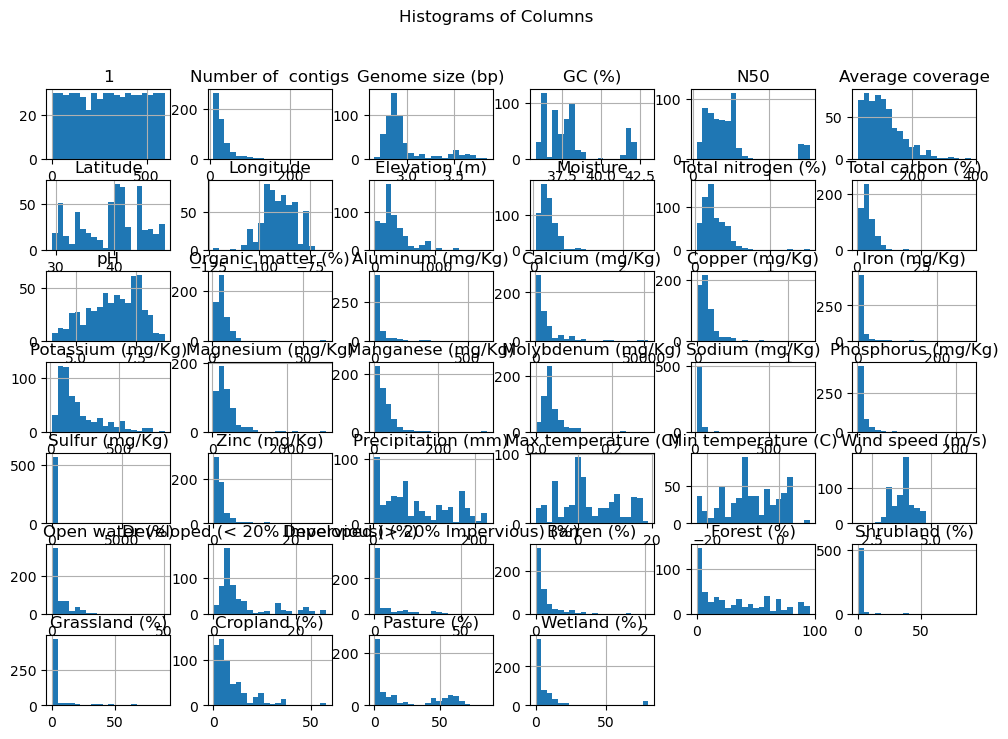

In [31]:
# Columns to test for normality
norm_test = [
    "Latitude",
    "Longitude",
    "Elevation (m)",
    "Moisture",
    "Total nitrogen (%)",
    "Total carbon (%)",
    "pH",
    "Organic matter (%)",
    "Aluminum (mg/Kg)",
    "Calcium (mg/Kg)",
    "Copper (mg/Kg)",
    "Iron (mg/Kg)",
    "Potassium (mg/Kg)",
    "Magnesium (mg/Kg)",
    "Manganese (mg/Kg)",
    "Molybdenum (mg/Kg)",
    "Sodium (mg/Kg)",
    "Phosphorus (mg/Kg)",
    "Sulfur (mg/Kg)",
    "Zinc (mg/Kg)",
    "Precipitation (mm)",
    "Max temperature (C)",
    "Min temperature (C)",
    "Wind speed (m/s)",
    "Open water (%)",
    "Developed (< 20% Impervious) (%)",
    "Developed (> 20% Impervious) (%)",
    "Barren (%)",
    "Forest (%)",
    "Shrubland (%)",
    "Grassland (%)",
    "Cropland (%)",
    "Pasture (%)",
    "Wetland (%)",
]

# Check normality using Shapiro-Wilk test
for column in norm_test:
    stat, p_value = shapiro(df_r[column])
    print(f"Shapiro-Wilk test for {column}: p-value = {p_value}")
    if p_value > 0.05:
        print(f"{column} appears to be normally distributed.\n")
    else:
        print(f"{column} does not appear to be normally distributed.\n")

# Visualize the distribution of data using histograms
df_r.hist(bins=20, figsize=(12, 8))
plt.suptitle("Histograms of Columns")
plt.show()

In [32]:
# All env parameters are not normally distributed - Mann-Whitney test

env_columns = [
    "Latitude",
    "Longitude",
    "Elevation (m)",
    "Moisture",
    "Total nitrogen (%)",
    "Total carbon (%)",
    "pH",
    "Organic matter (%)",
    "Aluminum (mg/Kg)",
    "Calcium (mg/Kg)",
    "Copper (mg/Kg)",
    "Iron (mg/Kg)",
    "Potassium (mg/Kg)",
    "Magnesium (mg/Kg)",
    "Manganese (mg/Kg)",
    "Molybdenum (mg/Kg)",
    "Sodium (mg/Kg)",
    "Phosphorus (mg/Kg)",
    "Sulfur (mg/Kg)",
    "Zinc (mg/Kg)",
    "Precipitation (mm)",
    "Max temperature (C)",
    "Min temperature (C)",
    "Wind speed (m/s)",
    "Open water (%)",
    "Developed (< 20% Impervious) (%)",
    "Developed (> 20% Impervious) (%)",
    "Barren (%)",
    "Forest (%)",
    "Shrubland (%)",
    "Grassland (%)",
    "Cropland (%)",
    "Pasture (%)",
    "Wetland (%)",
]

# List of columns to compare using Mann-Whitney - all is not normally distributed
env_mann = [
    "Latitude",
    "Longitude",
    "Elevation (m)",
    "Moisture",
    "Total nitrogen (%)",
    "Total carbon (%)",
    "pH",
    "Organic matter (%)",
    "Aluminum (mg/Kg)",
    "Calcium (mg/Kg)",
    "Copper (mg/Kg)",
    "Iron (mg/Kg)",
    "Potassium (mg/Kg)",
    "Magnesium (mg/Kg)",
    "Manganese (mg/Kg)",
    "Molybdenum (mg/Kg)",
    "Sodium (mg/Kg)",
    "Phosphorus (mg/Kg)",
    "Sulfur (mg/Kg)",
    "Zinc (mg/Kg)",
    "Precipitation (mm)",
    "Max temperature (C)",
    "Min temperature (C)",
    "Wind speed (m/s)",
    "Open water (%)",
    "Developed (< 20% Impervious) (%)",
    "Developed (> 20% Impervious) (%)",
    "Barren (%)",
    "Forest (%)",
    "Shrubland (%)",
    "Grassland (%)",
    "Cropland (%)",
    "Pasture (%)",
    "Wetland (%)",
]

# Column containing the sensu information
sensu = "sensu"

# List to store results
results_list = []

# Perform the test for each column
for column in env_columns:
    group1 = df_r[df_r[sensu] == "strictu"][column]
    group2 = df_r[df_r[sensu] == "lato"][column]

    if column in env_mann:
        # Mann-Whitney U test for non-normally distributed data
        stat, p_value = mannwhitneyu(group1, group2)
        test_type = "Mann-Whitney U"
        # Calculate medians for each group
        measure_group1, measure_group2 = group1.median(), group2.median()
    else:
        # Independent t-test for normally distributed data
        stat, p_value = ttest_ind(group1, group2)
        test_type = "t-test"
        # Calculate means for each group
        measure_group1, measure_group2 = group1.mean(), group2.mean()

    # Determine which group has a higher or lower measure
    if measure_group1 > measure_group2:
        result_summary = "'stricto' has a higher measure than 'lato'"
    elif measure_group1 < measure_group2:
        result_summary = "'lato' has a higher measure than 'stricto'"
    else:
        result_summary = "Both have the same measure"

    result = {
        "Environmental Parameter": column,
        "Sensu": "Listeria sensu stricto vs sensu lato",
        "Test Type": test_type,
        "Measure for 'Listeria sensu stricto'": measure_group1,
        "Measure for 'Listeria sensu lato'": measure_group2,
        "Statistical Test": stat,
        "p-value": p_value,
        "Result Summary": result_summary,
    }

    results_list.append(result)

# Create a DataFrame from the results list
combined_results_df = pd.DataFrame(results_list)

# Apply FDR correction to p-values
valid_p_values = combined_results_df["p-value"].dropna()  # Drop NaN values if any
rejected, corrected_p_values, _, _ = multipletests(valid_p_values, method="fdr_bh")

# Add the corrected p-values to the DataFrame
combined_results_df.loc[
    ~combined_results_df["p-value"].isna(), "FDR Corrected p-value"
] = corrected_p_values

# Define significance level based on FDR-corrected P < 0.05
combined_results_df["Significant FDR"] = (
    combined_results_df["FDR Corrected p-value"] < 0.05
)

results_list.append(result)

In [33]:
# Adding a new column group the environmental parameters for later visualisation
combined_results_df["class"] = combined_results_df["Environmental Parameter"].apply(
    lambda x: "Geographic"
    if x in ["Latitude", "Longitude", "Elevation (m)"]
    else (
        "Soil properties"
        if x
        in [
            "Moisture",
            "Total nitrogen (%)",
            "Total carbon (%)",
            "pH",
            "Organic matter (%)",
            "Aluminum (mg/Kg)",
            "Calcium (mg/Kg)",
            "Copper (mg/Kg)",
            "Iron (mg/Kg)",
            "Potassium (mg/Kg)",
            "Magnesium (mg/Kg)",
            "Manganese (mg/Kg)",
            "Molybdenum (mg/Kg)",
            "Sodium (mg/Kg)",
            "Phosphorus (mg/Kg)",
            "Sulfur (mg/Kg)",
            "Zinc (mg/Kg)",
        ]
        else (
            "Climate"
            if x
            in [
                "Precipitation (mm)",
                "Max temperature (C)",
                "Min temperature (C)",
                "Wind speed (m/s)",
            ]
            else (
                "Land use"
                if x
                in [
                    "Open water (%)",
                    "Developed (< 20% Impervious) (%)",
                    "Developed (> 20% Impervious) (%)",
                    "Barren (%)",
                    "Forest (%)",
                    "Shrubland (%)",
                    "Grassland (%)",
                    "Cropland (%)",
                    "Pasture (%)",
                    "Wetland (%)",
                ]
                else ""
            )
        )
    )
)

In [34]:
# Define conditions for later visualisation purpose
conditions = [
    (combined_results_df["Significant FDR"] == True)
    & (combined_results_df["class"] == "Geographic"),
    (combined_results_df["Significant FDR"] == True)
    & (combined_results_df["class"] == "Soil properties"),
    (combined_results_df["Significant FDR"] == True)
    & (combined_results_df["class"] == "Climate"),
    (combined_results_df["Significant FDR"] == True)
    & (combined_results_df["class"] == "Land use"),
    (combined_results_df["Significant FDR"] == False),
]

# Define corresponding color codes
colors = ["#5499C7", "#C0392B", "#D4AC0D", "#16A085", "#999999"]

    #"Geographic": "#5499C7",
    #"Soil properties": "#C0392B",
    #"Climate": "#D4AC0D",
    #"Land use": "#16A085",

# Create a new column 'Color' based on conditions
combined_results_df["Color"] = pd.Series(
    np.select(conditions, colors, default="#999999")
)

In [35]:
# Export the output,irrespective of significance, as a CSV for later visualisation
combined_results_df.to_csv(out_path + "env_compare_stricto_lato.csv", index=False)

In [36]:
df_volcano = pd.read_csv(out_path + "env_compare_stricto_lato.csv")

# Adding a column of renamed values to be plotted on the volcano plot later
rename_env = {
    "Latitude": "Latitude",
    "Longitude": "Longitude",
    "Elevation (m)": "Elevation",
    "Moisture": "Moisture",
    "Total nitrogen (%)": "TN",
    "Total carbon (%)": "TC",
    "pH": "pH",
    "Organic matter (%)": "Organic matter",
    "Aluminum (mg/Kg)": "Al",
    "Calcium (mg/Kg)": "Ca",
    "Copper (mg/Kg)": "Cu",
    "Iron (mg/Kg)": "Fe",
    "Potassium (mg/Kg)": "K",
    "Magnesium (mg/Kg)": "Mg",
    "Manganese (mg/Kg)": "Mn",
    "Molybdenum (mg/Kg)": "Molybdenum",
    "Sodium (mg/Kg)": "Na",
    "Phosphorus (mg/Kg)": "P",
    "Sulfur (mg/Kg)": "S",
    "Zinc (mg/Kg)": "Zn",
    "Precipitation (mm)": "Precipitation",
    "Max temperature (C)": "Max. temp.",
    "Min temperature (C)": "Min. temp.",
    "Wind speed (m/s)": "Wind speed",
    "Open water (%)": "Open water",
    "Developed (< 20% Impervious) (%)": "Developed, < 20% Impervious",
    "Developed (> 20% Impervious) (%)": "Developed, > 20% Impervious",
    "Barren (%)": "Barren",
    "Forest (%)": "Forest",
    "Shrubland (%)": "Shrubland",
    "Grassland (%)": "Grassland",
    "Cropland (%)": "Cropland",
    "Pasture (%)": "Pasture",
    "Wetland (%)": "Wetland",
}

# Create a new 'env_legend' column with renamed values
df_volcano["env_legend"] = df_volcano["Environmental Parameter"].replace(rename_env)

/localscratch/ipykernel_8107/137372290.py:98: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles, [class_colors[c] for c in df_volcano["class"].unique()]


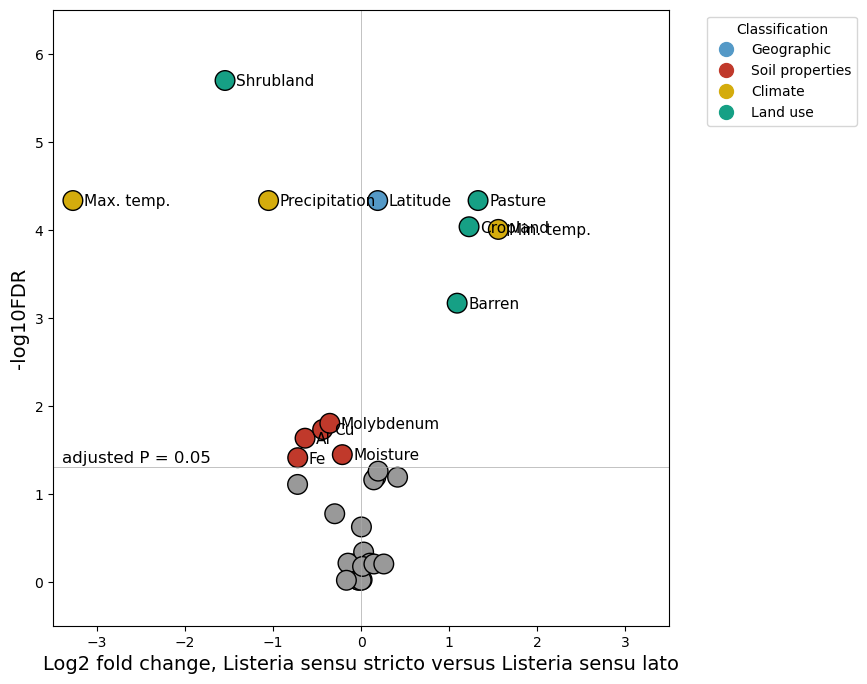

In [37]:
from matplotlib.lines import Line2D

## For plotting volcano plot

# Define class_colors based on your classes
class_colors = {
    "Geographic": "#5499C7",
    "Soil properties": "#C0392B",
    "Climate": "#D4AC0D",
    "Land use": "#16A085",
}

# Calculate log2 fold change - the x-axis for the volcano plot
df_volcano["Log2FoldChange"] = np.log2(
    (df_volcano["Measure for 'Listeria sensu stricto'"])  # + epsilon)
    / (df_volcano["Measure for 'Listeria sensu lato'"])  # + epsilon)
)

# Set the figure size to be square
plt.rcParams["figure.figsize"] = (8, 8)

# Call plt.subplots to get the figure and axis objects
fig, ax = plt.subplots()

# Create legend handles and labels
legend_handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=class_colors[c],
        markersize=10,
        label=c,
        
    )
    for c in df_volcano["class"].unique()
]

# Plotting the results
scatter = ax.scatter(
    df_volcano["Log2FoldChange"],
    -np.log10(df_volcano["FDR Corrected p-value"]),
    c=df_volcano["Color"],  # Use the 'Color' column for coloring
    s=200,  # Adjust the point size as needed
    edgecolors='black',
)

# Add a vertical line at x-axis = 0
ax.axvline(x=0, color="darkgrey", linestyle="-", linewidth=0.5)

# Add a horizontal line at -log10(0.05) on the y-axis
ax.axhline(y=-np.log10(0.05), color="darkgrey", linestyle="-", linewidth=0.5)

# Annotate the x-axis at y=-log10(0.05)
ax.text(-3.4, -np.log10(0.04), "adjusted P = 0.05", color="black",
        ha="left", va="center", fontsize=12)

# Annotate points with 'env_legend' values for points with FDR corrected p-value < 0.05
for i, row in df_volcano.iterrows():
    if -np.log10(row["FDR Corrected p-value"]) >= -np.log10(0.053):
        ax.annotate(
            row["env_legend"],
            (row["Log2FoldChange"], -np.log10(row["FDR Corrected p-value"])),
            textcoords="offset points",
            xytext=(8, -4),  # Adjust the xytext to move the annotation to the right
            ha="left",  # Adjust ha to left-align the annotation
            fontsize=11,
            color="black",  # Set the label color to black
        )

# Set x-axis range
ax.set_xlim(-3.5, 3.5)

# Set y-axis range
ax.set_ylim(-0.5, 6.5)

# Set equal aspect ratio to make the plot square
ax.set_aspect("equal", adjustable="box")

# Increase font size for axis labels and ticks
ax.set_xlabel("Log2 fold change, Listeria sensu stricto versus Listeria sensu lato", fontsize=14)
ax.set_ylabel("-log10FDR", fontsize=14)

# Hide the grid
ax.grid(False)

# Add legend outside the plot
legend = ax.legend(
    handles=legend_handles,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title="Classification",
)

# Set the fontsize for legend items
for item, color in zip(
    legend.legendHandles, [class_colors[c] for c in df_volcano["class"].unique()]
):
    item.set_markerfacecolor(color)
    item.set_markeredgecolor(color)

# Save the plot as a PDF at 600 dpi
plt.savefig(
    "volcano_plot_with_legend.pdf",
    dpi=600,
    bbox_inches="tight",
    bbox_extra_artists=[legend],
)

plt.show()

### Fig. 4f Mantel tests between ARG sequence dissimilarity and environmental variables

In [83]:
### Importing Packages
import glob
import os
import time

import numpy as np
import pandas as pd
import statsmodels.api as sm
from Bio import SeqIO
from haversine import Unit, haversine
from Levenshtein import distance as levenshtein_distance
from scipy import stats
from skbio.stats.distance import mantel

pd.set_option("display.max_columns", 200)

In [84]:
### files
files = glob.glob("/projects/leaph/yingxian/AMR_Listeria/phylo_amr/phylo_arg_corrected_110224/muscle/aligned/*")
files

['/projects/leaph/yingxian/AMR_Listeria/phylo_amr/phylo_arg_corrected_110224/muscle/aligned/norB_align.fasta',
 '/projects/leaph/yingxian/AMR_Listeria/phylo_amr/phylo_arg_corrected_110224/muscle/aligned/sul_align.fasta',
 '/projects/leaph/yingxian/AMR_Listeria/phylo_amr/phylo_arg_corrected_110224/muscle/aligned/lin_align.fasta',
 '/projects/leaph/yingxian/AMR_Listeria/phylo_amr/phylo_arg_corrected_110224/muscle/aligned/fosX_align.fasta',
 '/projects/leaph/yingxian/AMR_Listeria/phylo_amr/phylo_arg_corrected_110224/muscle/aligned/mprF_align.fasta']

In [85]:
for i in range(len(files)):
    genome_id_list = []
    f_seq = SeqIO.parse(open(files[i]), "fasta")
    for fs in f_seq:
        genome_id_list.append(fs.id.split("_", 1)[0])
    print(
        f"Before duplicates:{len((genome_id_list))}.. After_duplicates:{len(set(genome_id_list))}"
    )

Before duplicates:347.. After_duplicates:347
Before duplicates:482.. After_duplicates:482
Before duplicates:491.. After_duplicates:491
Before duplicates:361.. After_duplicates:361
Before duplicates:489.. After_duplicates:489


In [86]:
# Getting the Levenshtein distance between all the sequences
def get_the_dist_matrix(path):
    fasta_sequences = SeqIO.parse(path, "fasta")
    distance_dict = {}
    item_list = []
    for fasta in fasta_sequences:
        item_list.append(fasta)

    for i in range(len(item_list)):
        for j in range(len(item_list)):
            name_i = item_list[i].id
            name_j = item_list[j].id
            if name_i not in distance_dict.keys():
                distance_dict[name_i] = {}
                try:
                    distance_dict[name_i][name_j] = distance_dict[name_j][name_i]
                except:
                    distance_dict[name_i][name_j] = levenshtein_distance(
                        str(item_list[i].seq), str(item_list[j].seq)
                    )
            else:
                if name_j not in distance_dict[name_i].keys():
                    try:
                        distance_dict[name_i][name_j] = distance_dict[name_j][name_i]
                    except:
                        distance_dict[name_i][name_j] = levenshtein_distance(
                            str(item_list[i].seq), str(item_list[j].seq)
                        )
                else:
                    pass
    return pd.DataFrame.from_dict(distance_dict)

In [87]:
## Storing all the distances in a dictionary
mat_list = {}
for i in files:
    nm = i.split("/")[-1].replace("_align.fasta", "")
    mat_list[nm] = get_the_dist_matrix(i)

In [88]:
# Computing Euclidean distances between environmental variables for every pair of genomes
## Map data
MapData = pd.read_csv(
    "/projects/leaph/shared/project_data/listeria_US/Listeria_genomes.csv"
)
print(MapData.shape)
#MapData.head(2)

(594, 15)


In [89]:
### Importing Env data
EnvData = pd.read_csv("/projects/leaph/shared/project_data/listeria_US/environ_all.csv")
EnvData.rename(columns={"Sample ID ": "Sample ID"}, inplace=True)
print(EnvData.shape)
#EnvData.head(2)

(1004, 35)


In [90]:
### Get the difference between the environment variables
def get_env_difference(env_data, map_data, genome_id):
    env_data_1 = pd.merge(
        map_data[["Isolate ID", "Sample ID"]], env_data, on=["Sample ID"], how="inner"
    )
    env_data_mod_1 = env_data_1.drop(columns=["Sample ID", "Latitude", "Longitude"])
    env_data_mod_1.set_index("Isolate ID", inplace=True)
    row_to_sub = env_data_mod_1[env_data_mod_1.index == genome_id].iloc[0, :]
    env_data_mod_1_1 = abs(env_data_mod_1 - row_to_sub)
    ## Lat long distance
    env_data_mod_2 = env_data_1[["Isolate ID", "Latitude", "Longitude"]]
    req_loc = env_data_mod_2[env_data_mod_2["Isolate ID"] == genome_id]
    samp_loc = (req_loc.iloc[0, 1], req_loc.iloc[0, 2])
    env_data_mod_2.loc[:, "distance"] = env_data_mod_2.apply(
        lambda x: haversine((x["Latitude"], x["Longitude"]), samp_loc), axis=1
    )
    env_data_distance_merged = pd.merge(
        env_data_mod_2[["Isolate ID", "distance"]],
        env_data_mod_1_1.reset_index(),
        on=["Isolate ID"],
        how="inner",
    )
    env_data_distance_merged["Base_Genome_ID"] = genome_id
    return env_data_distance_merged

In [91]:
## get pairwise distances for all the genome samples
def getPairWiseDist(gene_dist_mat):
    # gene_dist_mat = mat_list[fasta_name].copy()
    gene_dist_mat.columns = [_.split("_")[0] for _ in gene_dist_mat.columns]
    gene_dist_mat.index = [_.split("_")[0] for _ in gene_dist_mat.index]
    gene_dist_mat_1 = gene_dist_mat.stack().reset_index()
    gene_dist_mat_1 = gene_dist_mat.stack().reset_index()
    gene_dist_mat_1.rename(
        columns={
            "level_0": "Genome_ID_1",
            "level_1": "Genome_ID_2",
            0: "Gene_distance",
        },
        inplace=True,
    )
    gene_dist_mat_2 = gene_dist_mat_1[
        ~pd.DataFrame(
            np.sort(gene_dist_mat_1[["Genome_ID_1", "Genome_ID_2"]].values, 1)
        ).duplicated()
    ]
    gene_dist_mat_2[["Genome_ID_1", "Genome_ID_2"]] = np.sort(
        gene_dist_mat_2[["Genome_ID_1", "Genome_ID_2"]].values
    )
    print(gene_dist_mat_1.shape, gene_dist_mat_2.shape)

    gene_env_list = []
    for i in gene_dist_mat_2.Genome_ID_1.unique():
        gene_env_list.append(get_env_difference(EnvData, MapData, i))
    final_env_data = pd.concat(gene_env_list)
    final_env_data_1 = final_env_data.loc[
        :,
        [
            "Base_Genome_ID",
            "Isolate ID",
            "distance",
            "Elevation (m)",
            "Moisture",
            "Total nitrogen (%)",
            "Total carbon (%)",
            "pH",
            "Organic matter (%)",
            "Aluminum (mg/Kg)",
            "Calcium (mg/Kg)",
            "Copper (mg/Kg)",
            "Iron (mg/Kg)",
            "Potassium (mg/Kg)",
            "Magnesium (mg/Kg)",
            "Manganese (mg/Kg)",
            "Molybdenum (mg/Kg)",
            "Sodium (mg/Kg)",
            "Phosphorus (mg/Kg)",
            "Sulfur (mg/Kg)",
            "Zinc (mg/Kg)",
            "Precipitation (mm)",
            "Max temperature (C)",
            "Min temperature (C)",
            "Wind speed (m/s)",
            "Open water (%)",
            "Developed (< 20% Impervious) (%)",
            "Developed (> 20% Impervious) (%)",
            "Barren (%)",
            "Forest (%)",
            "Shrubland (%)",
            "Grassland (%)",
            "Cropland (%)",
            "Pasture (%)",
            "Wetland (%)",
        ],
    ]
    final_env_data_1.rename(
        columns={"Base_Genome_ID": "Genome_ID_1", "Isolate ID": "Genome_ID_2"},
        inplace=True,
    )
    final_env_data_1.reset_index(drop=True, inplace=True)
    final_env_data_2 = final_env_data_1[
        ~pd.DataFrame(
            np.sort(final_env_data_1[["Genome_ID_1", "Genome_ID_2"]].values, 1)
        ).duplicated()
    ]
    print(final_env_data_2.shape, final_env_data_1.shape)

    final_env_data_2[["Genome_ID_1", "Genome_ID_2"]] = np.sort(
        final_env_data_2[["Genome_ID_1", "Genome_ID_2"]].values
    )
    final_merged_data = pd.merge(
        gene_dist_mat_2, final_env_data_2, on=["Genome_ID_1", "Genome_ID_2"], how="left"
    )
    print(final_merged_data.shape, gene_dist_mat_2.shape, final_env_data_2.shape)
    final_merged_data_1 = final_merged_data.copy()
    final_merged_data_2 = final_merged_data.copy()
    final_merged_data_2.rename(
        columns={"Genome_ID_1": "Genome_ID_2", "Genome_ID_2": "Genome_ID_1"},
        inplace=True,
    )
    final_merged_all = pd.concat([final_merged_data_1, final_merged_data_2])
    return final_merged_all

In [92]:
for i in mat_list.keys():
    pair_wise_dist_mat = getPairWiseDist(mat_list[i])
    if not os.path.exists("./Pairwise_distances/"):
        os.makedirs("./Pairwise_distances/")
    pair_wise_dist_mat.to_csv(
        f"./Pairwise_distances/{i}_pairwise_distances.csv", index=False
    )

(120409, 3) (60378, 3)


/localscratch/ipykernel_8107/4228049533.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_dist_mat_2[["Genome_ID_1", "Genome_ID_2"]] = np.sort(
/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data_mod_2.loc[:, "distance"] = env_data_mod_2.apply(
/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

(146087, 35) (206118, 35)
(60378, 36) (60378, 3) (146087, 35)


/localscratch/ipykernel_8107/4228049533.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_env_data_2[["Genome_ID_1", "Genome_ID_2"]] = np.sort(
/localscratch/ipykernel_8107/4228049533.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_dist_mat_2[["Genome_ID_1", "Genome_ID_2"]] = np.sort(
/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(232324, 3) (116403, 3)


/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data_mod_2.loc[:, "distance"] = env_data_mod_2.apply(
/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data_mod_2.loc[:, "distance"] = env_data_mod_2.apply(
/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

(170387, 35) (286308, 35)
(116403, 36) (116403, 3) (170387, 35)


/localscratch/ipykernel_8107/4228049533.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_env_data_2[["Genome_ID_1", "Genome_ID_2"]] = np.sort(
/localscratch/ipykernel_8107/4228049533.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_dist_mat_2[["Genome_ID_1", "Genome_ID_2"]] = np.sort(
/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(241081, 3) (120786, 3)


/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data_mod_2.loc[:, "distance"] = env_data_mod_2.apply(
/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data_mod_2.loc[:, "distance"] = env_data_mod_2.apply(
/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

(171359, 35) (291654, 35)
(120786, 36) (120786, 3) (171359, 35)


/localscratch/ipykernel_8107/4228049533.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_env_data_2[["Genome_ID_1", "Genome_ID_2"]] = np.sort(
/localscratch/ipykernel_8107/4228049533.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_dist_mat_2[["Genome_ID_1", "Genome_ID_2"]] = np.sort(
/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(130321, 3) (65341, 3)


/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data_mod_2.loc[:, "distance"] = env_data_mod_2.apply(
/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data_mod_2.loc[:, "distance"] = env_data_mod_2.apply(
/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

(149454, 35) (214434, 35)
(65341, 36) (65341, 3) (149454, 35)


/localscratch/ipykernel_8107/4228049533.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_env_data_2[["Genome_ID_1", "Genome_ID_2"]] = np.sort(
/localscratch/ipykernel_8107/4228049533.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_dist_mat_2[["Genome_ID_1", "Genome_ID_2"]] = np.sort(
/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(239121, 3) (119805, 3)


/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data_mod_2.loc[:, "distance"] = env_data_mod_2.apply(
/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data_mod_2.loc[:, "distance"] = env_data_mod_2.apply(
/localscratch/ipykernel_8107/1983628393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

(171150, 35) (290466, 35)
(119805, 36) (119805, 3) (171150, 35)


/localscratch/ipykernel_8107/4228049533.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_env_data_2[["Genome_ID_1", "Genome_ID_2"]] = np.sort(


In [93]:
for j in glob.glob("./Pairwise_distances/*"):
    merged_data = pd.read_csv(j)
    temp_dist_1 = pd.pivot_table(
        merged_data[["Genome_ID_1", "Genome_ID_2", "Gene_distance"]],
        index="Genome_ID_1",
        columns="Genome_ID_2",
        values=["Gene_distance"],
        aggfunc="sum",
    )
    env_variable = []
    p_value_list = []
    coeff_list = []
    for i in merged_data.columns[3:]:
        temp_env_1 = pd.pivot_table(
            merged_data[["Genome_ID_1", "Genome_ID_2"] + [i]],
            index="Genome_ID_1",
            columns="Genome_ID_2",
            aggfunc="sum",
            values=[i],
        )
        result = mantel(temp_dist_1, temp_env_1, permutations=10000)
        env_variable.append(i)
        p_value_list.append(result[1])
        coeff_list.append(result[0])
    final_corr_df = pd.DataFrame(
        {"Env_Variables": env_variable, "Coeff": coeff_list, "P_values": p_value_list}
    )
    final_corr_df.sort_values(by="P_values", inplace=True, ascending=True)
    final_corr_df["fdr_adjusted_pvalue"] = sm.stats.fdrcorrection(
        final_corr_df["P_values"], alpha=0.05, method="indep", is_sorted=True
    )[1]
    if not os.path.exists("./Correlations"):
        os.makedirs("./Correlations")
    final_corr_df.to_csv(
        f"./Correlations/{j.split('/')[-1].split('_')[0]}_correlations_fdr_corrected.csv",
        index=False,
    )

In [94]:
## merging all correlation matrices
all_corr_list = []
corr_files = glob.glob("./Correlations/*")
for i in corr_files:
    temp_corr_df = pd.read_csv(i)
    temp_corr_df["ARG_type"] = i.split("/")[-1].split("_")[0]
    all_corr_list.append(temp_corr_df)
all_corr_df = pd.concat(all_corr_list)
all_corr_df.reset_index(drop=True)
#all_corr_df.head(10)

,Env_Variables,Coeff,P_values,fdr_adjusted_pvalue,ARG_type
0,distance,0.270672,0.000100,0.000550,fosX
1,Min temperature (C),0.138581,0.000100,0.000550,fosX
2,Max temperature (C),0.145682,0.000100,0.000550,fosX
3,Forest (%),0.194433,0.000100,0.000550,fosX
4,pH,0.121676,0.000100,0.000550,fosX
...,...,...,...,...,...
160,Moisture,0.010879,0.471453,0.536481,mprF
161,Barren (%),0.007373,0.582542,0.640796,mprF
162,Developed (> 20% Impervious) (%),-0.003271,0.793821,0.845035,mprF
163,Phosphorus (mg/Kg),0.001463,0.917408,0.946077,mprF


In [95]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import seaborn.matrix as smatrix

sns.set()

start_time_1 = time.time()
conditions = [
    all_corr_df["fdr_adjusted_pvalue"] <= 0.0001,
    all_corr_df["fdr_adjusted_pvalue"] <= 0.001,
    all_corr_df["fdr_adjusted_pvalue"] <= 0.01,
    all_corr_df["fdr_adjusted_pvalue"] <= 0.05,
    all_corr_df["fdr_adjusted_pvalue"] > 0.05,
]
choices = ["****", "***", "**", "*", " "]
all_corr_df["asterisk"] = np.select(conditions, choices, default=0)
print(f"Time took: {time.time()-start_time_1}")

all_corr_df.sort_values("Coeff", ascending=False, inplace=True)
#all_corr_df

Time took: 0.0009412765502929688


In [96]:
table = pd.pivot_table(
    all_corr_df,
    values="Coeff",
    index=["Env_Variables"],
    columns=["ARG_type"],
    aggfunc="mean",
)

In [97]:
### reindexing the table
new_index = [
    "distance",
    "Elevation (m)",
    "Moisture",
    "Total nitrogen (%)",
    "Total carbon (%)",
    "pH",
    "Organic matter (%)",
    "Aluminum (mg/Kg)",
    "Calcium (mg/Kg)",
    "Copper (mg/Kg)",
    "Iron (mg/Kg)",
    "Potassium (mg/Kg)",
    "Magnesium (mg/Kg)",
    "Manganese (mg/Kg)",
    "Molybdenum (mg/Kg)",
    "Sodium (mg/Kg)",
    "Phosphorus (mg/Kg)",
    "Sulfur (mg/Kg)",
    "Zinc (mg/Kg)",
    "Precipitation (mm)",
    "Max temperature (C)",
    "Min temperature (C)",
    "Wind speed (m/s)",
    "Open water (%)",
    "Developed (< 20% Impervious) (%)",
    "Developed (> 20% Impervious) (%)",
    "Barren (%)",
    "Forest (%)",
    "Shrubland (%)",
    "Grassland (%)",
    "Cropland (%)",
    "Pasture (%)",
    "Wetland (%)",
]
print(len(new_index))
table = table.reindex(new_index)
table.head(5)

33


ARG_type,fosX,lin,mprF,norB,sul
Env_Variables,,,,,
distance,0.270672,0.184348,0.213629,0.251420,0.159617
Elevation (m),0.057875,0.113234,0.087730,0.222905,0.026512
Moisture,0.003646,-0.002208,0.010879,-0.005417,0.020734
Total nitrogen (%),0.018371,0.011616,0.017222,0.043804,0.020327
Total carbon (%),0.036760,0.016317,0.021183,0.033654,0.033092


In [99]:
annot_mat = pd.pivot_table(
    all_corr_df,
    values="asterisk",
    index=["Env_Variables"],
    columns=["ARG_type"],
    aggfunc=",".join,
)
annot_mat = annot_mat.reindex(new_index)

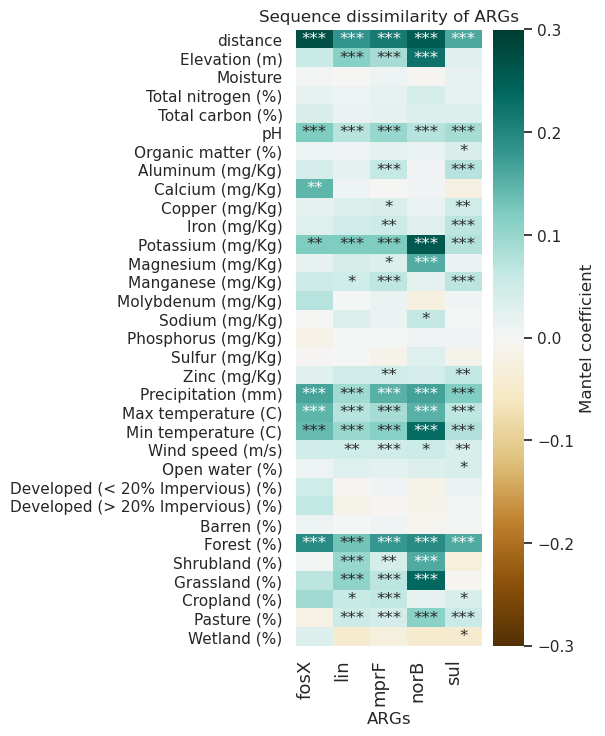

In [100]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (3, 8)
sns.heatmap(
    table,
    annot=annot_mat,
    vmin=-0.3,
    vmax=0.3,
    fmt="",
    cmap="BrBG",
    cbar_kws={"label": "Mantel coefficient"},
    ax=ax,
)
plt.xlabel("ARGs")
plt.xticks(fontsize=13, rotation=90, ha="right")
plt.ylabel("")
ax.set_title("Sequence dissimilarity of ARGs")
plt.savefig(out_path + "mantel.pdf", bbox_inches="tight", dpi=600)
plt.savefig(out_path + "mantel.png", bbox_inches="tight", dpi=600)
plt.show()

### Fig. 4g VPA showing the variation of the genetic divergence of norB 

In [55]:
# Loading dataframe and data pre-processing
df_env = pd.read_csv(
    "/projects/leaph/yingxian/AMR_Listeria/Data/Diversity_Analysis/In/genomes_env.csv",
    index_col=0,
)

df_norB_pairwise = pd.read_csv(
    "/projects/leaph/yingxian/AMR_Listeria/Data/Diversity_Analysis/arg_diversity/Pairwise_distances/norB_pairwise_distances.csv"
)

# Filter and drop rows where Genome_ID_1 and Genome_ID_2 are the same
df_norB_pairwise = df_norB_pairwise[
    df_norB_pairwise["Genome_ID_1"] != df_norB_pairwise["Genome_ID_2"]
]

# Further filter and drop rows with the patterns (a, b) or (b, a) - verified, the code is correct
df_norB_pairwise = df_norB_pairwise[
    ~df_norB_pairwise.apply(
        lambda row: tuple(sorted([row["Genome_ID_1"], row["Genome_ID_2"]])), axis=1
    ).duplicated()
]

# Drop NaN rows
df_norB_dropped_nan = df_norB_pairwise.dropna()

In [56]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [57]:
%R -i df_norB_dropped_nan

In [58]:
%%R 

library(vegan)
library(tidyverse)

norB_env_nan <- list(
  Geographic = df_norB_dropped_nan[, c(4:5)],
  Soil = df_norB_dropped_nan[, c(6:22)],
  Climate = df_norB_dropped_nan[, c(23:26)],
  `Land Use` = df_norB_dropped_nan[, c(27:36)]
)

norB_diverse_nan <- list(
  Diversification = df_norB_dropped_nan[, c(3)]
)

# Function to perform variation partitioning
VarPart <- function(norB_diverse_nan, norB_env_nan) {
  # PNG export
  png('norB_diversification.png', width = 900, height = 900)
  
  # Perform the analysis on the specified variables
  plot(
    varpart(
      norB_diverse_nan$Diversification,
      norB_env_nan$Geographic,
      norB_env_nan$Soil,
      norB_env_nan$Climate,
      norB_env_nan$`Land Use`  
    ),
    digits = 3,
    Xnames = c('Geographic','Soil', 'Climate', 'Land Use'),
    bg = c('#2A2CD5', '#D52A82', '#D5D32A', '#2AD57E'),
    cex = 1.5, # adjust font size
  )
  
  title(main = "VPA for diversification of norB")
  dev.off()

  # PDF export
  pdf('norB_diversification.pdf', width = 15, height = 15, pointsize = 12)

  # Perform the analysis on the specified variables
  plot(
    varpart(
      norB_diverse_nan$Diversification,
      norB_env_nan$Geographic,
      norB_env_nan$Soil,
      norB_env_nan$Climate,
      norB_env_nan$`Land Use`  
    ),
    digits = 3,
    Xnames = c('Geographic','Soil', 'Climate', 'Land Use'),
    bg = c('#2A2CD5', '#D52A82', '#D5D32A', '#2AD57E'),
    cex = 1.5, # adjust font size
  )

  title(main = "VPA for diversification of norB")
  dev.off()
}

# Call the function for partitioning
VarPart(norB_diverse_nan, norB_env_nan)

png 
  2 


### Supplmentary Fig. 4a-d VPA showing the variation of the genetic divergence of fosX, mprF, lin, and sul 

In [59]:
# For fosX
df_fosX_pairwise = pd.read_csv(
    "/projects/leaph/yingxian/AMR_Listeria/Data/Diversity_Analysis/arg_diversity/Pairwise_distances/fosX_pairwise_distances.csv"
)

# Filter and drop rows where Genome_ID_1 and Genome_ID_2 are the same
df_fosX_pairwise = df_fosX_pairwise[
    df_fosX_pairwise["Genome_ID_1"] != df_fosX_pairwise["Genome_ID_2"]
]

# Further filter and drop rows with the patterns (a, b) or (b, a) - verified, the code is correct
df_fosX_pairwise = df_fosX_pairwise[
    ~df_fosX_pairwise.apply(
        lambda row: tuple(sorted([row["Genome_ID_1"], row["Genome_ID_2"]])), axis=1
    ).duplicated()
]

#Drop NaN rows
df_fosX_dropped_nan = df_fosX_pairwise.dropna()

In [60]:
# For mprF
df_mprF_pairwise = pd.read_csv(
    "/projects/leaph/yingxian/AMR_Listeria/Data/Diversity_Analysis/arg_diversity/Pairwise_distances/mprF_pairwise_distances.csv"
)

# Filter and drop rows where Genome_ID_1 and Genome_ID_2 are the same
df_mprF_pairwise = df_mprF_pairwise[
    df_mprF_pairwise["Genome_ID_1"] != df_mprF_pairwise["Genome_ID_2"]
]

# Further filter and drop rows with the patterns (a, b) or (b, a) - verified, the code is correct
df_mprF_pairwise = df_mprF_pairwise[
    ~df_mprF_pairwise.apply(
        lambda row: tuple(sorted([row["Genome_ID_1"], row["Genome_ID_2"]])), axis=1
    ).duplicated()
]

# Drop NaN rows
df_mprF_dropped_nan = df_mprF_pairwise.dropna()

In [61]:
# For sul
df_sul_pairwise = pd.read_csv(
    "/projects/leaph/yingxian/AMR_Listeria/Data/Diversity_Analysis/arg_diversity/Pairwise_distances/sul_pairwise_distances.csv"
)

# Filter and drop rows where Genome_ID_1 and Genome_ID_2 are the same
df_sul_pairwise = df_sul_pairwise[
    df_sul_pairwise["Genome_ID_1"] != df_sul_pairwise["Genome_ID_2"]
]

# Further filter and drop rows with the patterns (a, b) or (b, a) - verified, the code is correct
df_sul_pairwise = df_sul_pairwise[
    ~df_sul_pairwise.apply(
        lambda row: tuple(sorted([row["Genome_ID_1"], row["Genome_ID_2"]])), axis=1
    ).duplicated()
]

# Drop NaN rows
df_sul_dropped_nan = df_sul_pairwise.dropna()

In [62]:
# For lin
df_lin_pairwise = pd.read_csv(
    "/projects/leaph/yingxian/AMR_Listeria/Data/Diversity_Analysis/arg_diversity/Pairwise_distances/lin_pairwise_distances.csv"
)

# Filter and drop rows where Genome_ID_1 and Genome_ID_2 are the same
df_lin_pairwise = df_lin_pairwise[
    df_lin_pairwise["Genome_ID_1"] != df_lin_pairwise["Genome_ID_2"]
]

# Further filter and drop rows with the patterns (a, b) or (b, a) - verified, the code is correct
df_lin_pairwise = df_lin_pairwise[
    ~df_lin_pairwise.apply(
        lambda row: tuple(sorted([row["Genome_ID_1"], row["Genome_ID_2"]])), axis=1
    ).duplicated()
]

# Drop NaN rows
df_lin_dropped_nan = df_lin_pairwise.dropna()

In [63]:
%R -i df_fosX_dropped_nan

In [64]:
%%R 

library(vegan)
library(tidyverse)

fosX_env_nan <- list(
  Geographic = df_fosX_dropped_nan[, c(4:5)],
  Soil = df_fosX_dropped_nan[, c(6:22)],
  Climate = df_fosX_dropped_nan[, c(23:26)],
  `Land Use` = df_fosX_dropped_nan[, c(27:36)]
)

fosX_diverse_nan <- list(
  Diversification = df_fosX_dropped_nan[, c(3)]
)

# Function to perform variation partitioning
VarPart <- function(fosX_diverse_nan, fosX_env_nan) {
  # PNG export
  png('fosX_diversification.png', width = 900, height = 900)
  
  # Perform the analysis on the specified variables
  plot(
    varpart(
      fosX_diverse_nan$Diversification,
      fosX_env_nan$Geographic,
      fosX_env_nan$Soil,
      fosX_env_nan$Climate,
      fosX_env_nan$`Land Use`  
    ),
    digits = 3,
    Xnames = c('Geographic','Soil', 'Climate', 'Land Use'),
    bg = c('#2A2CD5', '#D52A82', '#D5D32A', '#2AD57E'),
    cex = 1.5, # adjust font size
  )
  
  title(main = "VPA for diversification of fosX")
  dev.off()

  # PDF export
  pdf('fosX_diversification.pdf', width = 15, height = 15, pointsize = 12)

  # Perform the analysis on the specified variables
  plot(
    varpart(
      fosX_diverse_nan$Diversification,
      fosX_env_nan$Geographic,
      fosX_env_nan$Soil,
      fosX_env_nan$Climate,
      fosX_env_nan$`Land Use`  
    ),
    digits = 3,
    Xnames = c('Geographic','Soil', 'Climate', 'Land Use'),
    bg = c('#2A2CD5', '#D52A82', '#D5D32A', '#2AD57E'),
    cex = 1.5, # adjust font size
  )

  title(main = "VPA for diversification of fosX")
  dev.off()
}

# Call the function for partitioning
VarPart(fosX_diverse_nan, fosX_env_nan)

png 
  2 


In [65]:
%R -i df_mprF_dropped_nan

In [66]:
%%R 

library(vegan)
library(tidyverse)

mprF_env_nan <- list(
  Geographic = df_mprF_dropped_nan[, c(4:5)],
  Soil = df_mprF_dropped_nan[, c(6:22)],
  Climate = df_mprF_dropped_nan[, c(23:26)],
  `Land Use` = df_mprF_dropped_nan[, c(27:36)]
)

mprF_diverse_nan <- list(
  Diversification = df_mprF_dropped_nan[, c(3)]
)

# Function to perform variation partitioning
VarPart <- function(mprF_diverse_nan, mprF_env_nan) {
  # PNG export
  png('mprF_diversification.png', width = 900, height = 900)
  
  # Perform the analysis on the specified variables
  plot(
    varpart(
      mprF_diverse_nan$Diversification,
      mprF_env_nan$Geographic,
      mprF_env_nan$Soil,
      mprF_env_nan$Climate,
      mprF_env_nan$`Land Use`  
    ),
    digits = 3,
    Xnames = c('Geographic','Soil', 'Climate', 'Land Use'),
    bg = c('#2A2CD5', '#D52A82', '#D5D32A', '#2AD57E'),
    cex = 1.5, # adjust font size
  )
  
  title(main = "VPA for diversification of mprF")
  dev.off()

  # PDF export
  pdf('mprF_diversification.pdf', width = 15, height = 15, pointsize = 12)

  # Perform the analysis on the specified variables
  plot(
    varpart(
      mprF_diverse_nan$Diversification,
      mprF_env_nan$Geographic,
      mprF_env_nan$Soil,
      mprF_env_nan$Climate,
      mprF_env_nan$`Land Use`  
    ),
    digits = 3,
    Xnames = c('Geographic','Soil', 'Climate', 'Land Use'),
    bg = c('#2A2CD5', '#D52A82', '#D5D32A', '#2AD57E'),
    cex = 1.5, # adjust font size
  )

  title(main = "VPA for diversification of mprF")
  dev.off()
}

# Call the function for partitioning
VarPart(mprF_diverse_nan, mprF_env_nan)

png 
  2 


In [67]:
%R -i df_sul_dropped_nan

In [68]:
%%R 

library(vegan)
library(tidyverse)

sul_env_nan <- list(
  Geographic = df_sul_dropped_nan[, c(4:5)],
  Soil = df_sul_dropped_nan[, c(6:22)],
  Climate = df_sul_dropped_nan[, c(23:26)],
  `Land Use` = df_sul_dropped_nan[, c(27:36)]
)

sul_diverse_nan <- list(
  Diversification = df_sul_dropped_nan[, c(3)]
)

# Function to perform variation partitioning
VarPart <- function(sul_diverse_nan, sul_env_nan) {
  # PNG export
  png('sul_diversification.png', width = 900, height = 900)
  
  # Perform the analysis on the specified variables
  plot(
    varpart(
      sul_diverse_nan$Diversification,
      sul_env_nan$Geographic,
      sul_env_nan$Soil,
      sul_env_nan$Climate,
      sul_env_nan$`Land Use`  
    ),
    digits = 3,
    Xnames = c('Geographic','Soil', 'Climate', 'Land Use'),
    bg = c('#2A2CD5', '#D52A82', '#D5D32A', '#2AD57E'),
    cex = 1.5, # adjust font size
  )
  
  title(main = "VPA for diversification of sul")
  dev.off()

  # PDF export
  pdf('sul_diversification.pdf', width = 15, height = 15, pointsize = 12)

  # Perform the analysis on the specified variables
  plot(
    varpart(
      sul_diverse_nan$Diversification,
      sul_env_nan$Geographic,
      sul_env_nan$Soil,
      sul_env_nan$Climate,
      sul_env_nan$`Land Use`  
    ),
    digits = 3,
    Xnames = c('Geographic','Soil', 'Climate', 'Land Use'),
    bg = c('#2A2CD5', '#D52A82', '#D5D32A', '#2AD57E'),
    cex = 1.5, # adjust font size
  )

  title(main = "VPA for diversification of sul")
  dev.off()
}

# Call the function for partitioning
VarPart(sul_diverse_nan, sul_env_nan)

png 
  2 


In [69]:
%R -i df_lin_dropped_nan

In [70]:
%%R 

library(vegan)
library(tidyverse)

lin_env_nan <- list(
  Geographic = df_lin_dropped_nan[, c(4:5)],
  Soil = df_lin_dropped_nan[, c(6:22)],
  Climate = df_lin_dropped_nan[, c(23:26)],
  `Land Use` = df_lin_dropped_nan[, c(27:36)]
)

lin_diverse_nan <- list(
  Diversification = df_lin_dropped_nan[, c(3)]
)

# Function to perform variation partitioning
VarPart <- function(lin_diverse_nan, lin_env_nan) {
  # PNG export
  png('lin_diversification.png', width = 900, height = 900)
  
  # Perform the analysis on the specified variables
  plot(
    varpart(
      lin_diverse_nan$Diversification,
      lin_env_nan$Geographic,
      lin_env_nan$Soil,
      lin_env_nan$Climate,
      lin_env_nan$`Land Use`  
    ),
    digits = 3,
    Xnames = c('Geographic','Soil', 'Climate', 'Land Use'),
    bg = c('#2A2CD5', '#D52A82', '#D5D32A', '#2AD57E'),
    cex = 1.5, # adjust font size
  )
  
  title(main = "VPA for diversification of lin")
  dev.off()

  # PDF export
  pdf('lin_diversification.pdf', width = 15, height = 15, pointsize = 12)

  # Perform the analysis on the specified variables
  plot(
    varpart(
      lin_diverse_nan$Diversification,
      lin_env_nan$Geographic,
      lin_env_nan$Soil,
      lin_env_nan$Climate,
      lin_env_nan$`Land Use`  
    ),
    digits = 3,
    Xnames = c('Geographic','Soil', 'Climate', 'Land Use'),
    bg = c('#2A2CD5', '#D52A82', '#D5D32A', '#2AD57E'),
    cex = 1.5, # adjust font size
  )

  title(main = "VPA for diversification of lin")
  dev.off()
}

# Call the function for partitioning
VarPart(lin_diverse_nan, lin_env_nan)

png 
  2 


## Supplementary Fig. 2 MDS for genomes with and without ARGs based on for environmental conditions

In [71]:
# get significant div_sig_env from above correlation analysis
div_sig_env = list(
    environment_corr_df[environment_corr_df["fdr_adjusted_pvalue"] < 0.05]["Env_factor"]
)

In [72]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

env = pd.read_csv(shared + "environ_all.csv", index_col=0)
env = env.fillna(env.mean())
genome = pd.read_csv(shared + "Listeria_genomes.csv", index_col=0)
genome_id = genome[["Sample ID"]]

genomes_env_only = pd.merge(
    genome_id, env, how="left", left_on="Sample ID", right_index=True
).drop(columns=["Sample ID"])

genomes_env_sig = genomes_env_only[genomes_env_only.columns.intersection(div_sig_env)]


# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(genomes_env_sig)

scaled_data

# Compute the distance matrix
distance_matrix = pairwise_distances(scaled_data, metric="euclidean")

# Perform MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
mds_coordinates = mds.fit_transform(distance_matrix)

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [73]:
from matplotlib.patches import Ellipse
from skbio.stats.distance import DistanceMatrix, permanova

# functions for making ellipse


def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)


def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [74]:
# Classify genomes into groups based richness

arg_div = pd.read_csv(
    out_path + "ARG_functional_diversity.csv", index_col=0
).sort_index()

mds_2d_df = pd.DataFrame(mds_coordinates).set_index(genomes_env_sig.index)
mds_div = pd.merge(mds_2d_df, arg_div, left_index=True, right_index=True)


# Define the criteria function
def assign_group(value):
    if value < 1:
        return "Absence"
    #     elif 2 <= value < 4:
    #         return 'Medium richness'
    else:
        return "Presence"


# Apply the criteria function to column 'B' and create a new column 'Group'
mds_div["group"] = mds_div["richness"].apply(assign_group)

In [75]:
# perform permanova test on grouping

grouping = list(mds_div["group"])

symmetric_distance_matrix = (distance_matrix + distance_matrix.T) / 2
symmetric_distance_matrix = DistanceMatrix(
    symmetric_distance_matrix, ids=genomes_env_sig.index
)

permanova_results = permanova(symmetric_distance_matrix, grouping, permutations=999)
print(permanova_results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     594
number of groups                  2
test statistic             6.768482
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


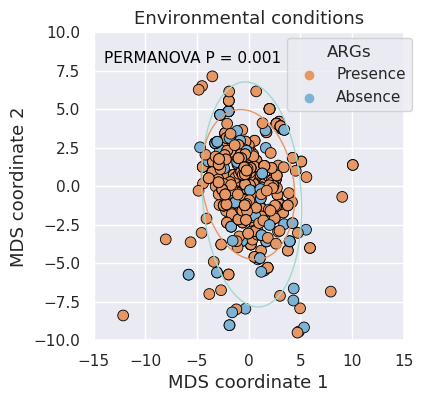

In [76]:
# MDS Plot
plt.rcParams["figure.figsize"] = (4, 4)
ax = sns.scatterplot(
    x=0,
    y=1,
    hue="group",
    data=mds_div,
    palette=["#E59866", "#7FB3D5"],
    s=60,
    edgecolor="black",
)

low_mean = mds_div[mds_div["group"] == "Absence"][[0, 1]].values
high_mean = mds_div[mds_div["group"] == "Presence"][[0, 1]].values


e1 = plot_point_cov(low_mean)
e3 = plot_point_cov(high_mean)

e1.set_facecolor("none")
e3.set_facecolor("none")
e1.set_edgecolor("#A2D9CE")
e3.set_edgecolor("#E59866")

ax.set_title("Environmental conditions", size=13)
ax.legend(title="ARGs", bbox_to_anchor=(0.6, 0.72))
plt.xlim(-15, 15)
plt.ylim(-10, 10)
plt.xlabel("MDS coordinate 1", size=13)
plt.ylabel("MDS coordinate 2", size=13)
plt.text(-14, 8, "PERMANOVA P = 0.001", color="black", fontsize=11)
plt.savefig(out_path + "MDS_richness_2classes.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [77]:
# prepare dataset for ML
df_ML = pd.merge(
    genomes_env_only, mds_div[["group"]], left_index=True, right_index=True
)
df_ML.to_csv(out_path + "ARG_2classes_env.csv")

## Supplementary Fig. 6 Comparing the prevalence of present ARGs and functional ARGs between the predicted outputs from BIGSdb-Lm and CARD

In [78]:
df1 = pd.read_csv(blast_sum_path + "ARG_present_prop.csv")
df2 = pd.read_csv(blast_sum_path + "ARG_functional_prop.csv")
df3 = pd.read_csv(card_path + "CARD_present_prop.csv")
df4 = pd.read_csv(card_path + "CARD_functional_prop.csv")

# Merging the datasets for later visualisation
df1_2 = pd.merge(
    df1,
    df2,
    left_on=["gene"],
    right_on=["gene"],
    how="inner",
)

# Rename the columns
df1_2.rename(
    columns={
        "0_x": "BIGSdb_present_%",
        "0_y": "BIGSdb_functional_%",
    },
    inplace=True,
)

# Remove rows with zero values in the 'BIGSdb_present_%' and 'BIGSdb_functional_%' column
df1_2 = df1_2[df1_2['BIGSdb_present_%'] != 0]
df1_2 = df1_2[df1_2['BIGSdb_functional_%'] != 0]

df3_4 = pd.merge(
    df3,
    df4,
    left_on=["gene"],
    right_on=["gene"],
    how="inner",
)

# Rename the columns
df3_4.rename(
    columns={
        "0_x": "CARD_present_%",
        "0_y": "CARD_functional_%",
    },
    inplace=True,
)

# Remove rows with zero values in the 'CARD_present_%' and 'CARD_functional_%' column
df3_4 = df3_4[df3_4['CARD_present_%'] != 0]
df3_4 = df3_4[df3_4['CARD_functional_%'] != 0]

# Rename the row in 'gene' column to standardize for comparison
df1_2["gene"].replace(
    {
        "lmo1695": "mprF",
        "lmo0919": "lin",
    },
    inplace=True
)

df3_4["gene"].replace(
    {
        "Lmon_mprF": "mprF",
        "FosX": "fosX",
        "FosXCC": "fosXCC"
    },
    inplace=True
)

# Merged df1_2 and df3_4 based on the gene column and keep all column
df1_2_3_4 = pd.merge(
    df1_2,
    df3_4,
    left_on=["gene"],
    right_on=["gene"],
    how="outer",
)

# Replace 'NaN' value with zero
df1_2_3_4.fillna(0, inplace=True)

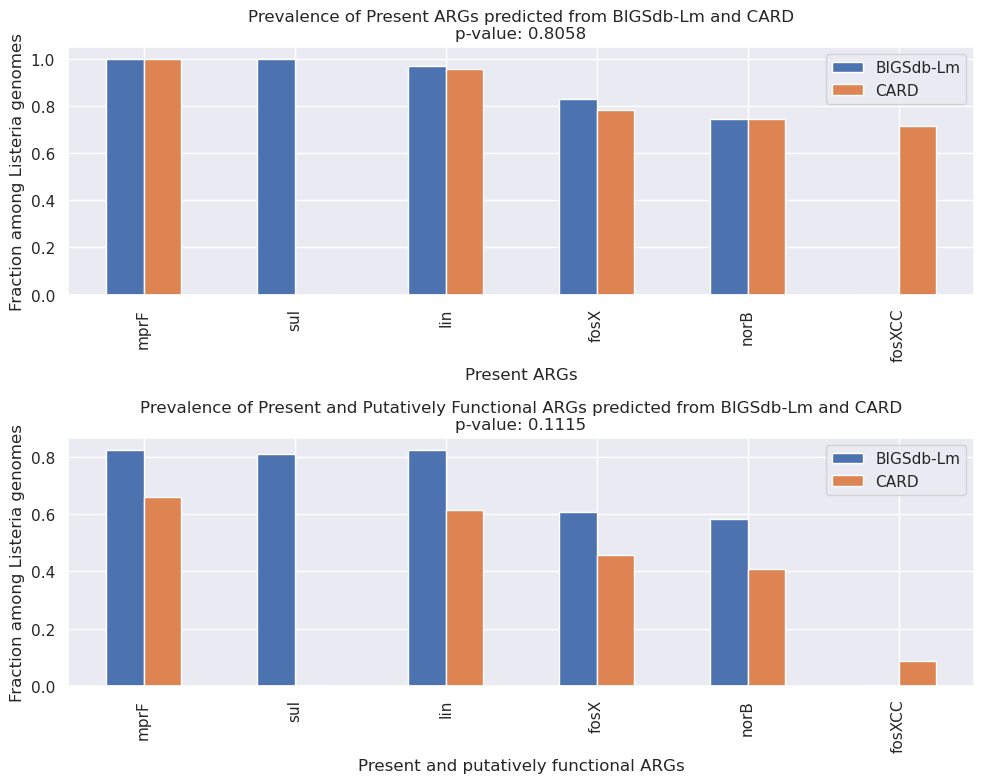

In [79]:
# Visualisation and comparison
# Select the columns for comparison
df_compare_present = df1_2_3_4[['gene', 'BIGSdb_present_%', 'CARD_present_%']]
df_compare_functional = df1_2_3_4[['gene', 'BIGSdb_functional_%', 'CARD_functional_%']]

# Set 'gene' as the index for comparison
df_compare_present.set_index('gene', inplace=True)
df_compare_functional.set_index('gene', inplace=True)

# Paired t-test for each gene
t_stat_present, p_value_present = ttest_rel(df_compare_present['BIGSdb_present_%'], df_compare_present['CARD_present_%'])
t_stat_functional, p_value_functional = ttest_rel(df_compare_functional['BIGSdb_functional_%'], df_compare_functional['CARD_functional_%'])

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

df_compare_present.plot(kind='bar', ax=ax1)
ax1.set_title(f'Prevalence of Present ARGs predicted from BIGSdb-Lm and CARD\np-value: {p_value_present:.4f}')
ax1.set_ylabel('Fraction among Listeria genomes')
ax1.set_xlabel('Present ARGs')
ax1.legend(['BIGSdb-Lm', 'CARD'])

df_compare_functional.plot(kind='bar', ax=ax2)
ax2.set_title(f'Prevalence of Present and Putatively Functional ARGs predicted from BIGSdb-Lm and CARD\np-value: {p_value_functional:.4f}')
ax2.set_ylabel('Fraction among Listeria genomes')
ax2.set_xlabel('Present and putatively functional ARGs')
ax2.legend(['BIGSdb-Lm', 'CARD'])

# Add p-values below the titles
#ax1.text(0.5, -0.2, f'p-value: {p_value_present:.4f}', ha='center', transform=ax1.transAxes, fontsize=10)
#ax2.text(0.5, -0.2, f'p-value: {p_value_functional:.4f}', ha='center', transform=ax2.transAxes, fontsize=10)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Export the plot as PDF
plt.savefig('fig_s2.pdf', bbox_inches='tight', dpi=600)

# Display the plot
plt.tight_layout()
plt.show()

## Supplmentary Fig. 7: Correlation between diversity and richness

In [80]:
# functional ARGs
arg = pd.read_csv(blast_sum_path + "ARG_functional_matrix.csv", index_col=0)

# compute diversity & richness
arg_div = arg.apply(
    lambda x: pd.Series(
        [skbio.diversity.alpha.shannon(x), skbio.diversity.alpha.observed_otus(x)],
        index=["shannon", "richness"],
    ),
    axis="columns",
)

arg_div = arg_div.fillna(0)
arg_div.to_csv(out_path + "ARG_functional_diversity.csv")

# present ARGs
arg = pd.read_csv(blast_sum_path + "ARG_present_matrix.csv", index_col=0)

# compute diversity & richness
arg_div = arg.apply(
    lambda x: pd.Series(
        [skbio.diversity.alpha.shannon(x), skbio.diversity.alpha.observed_otus(x)],
        index=["shannon", "richness"],
    ),
    axis="columns",
)

arg_div = arg_div.fillna(0)
arg_div.to_csv(out_path + "ARG_present_diversity.csv")

/projects/leaph/.pyenv/versions/mambaforge/lib/python3.11/site-packages/skbio/diversity/alpha/_base.py:869: RuntimeWarning: invalid value encountered in divide
  freqs = counts / counts.sum()


0.9998306363052476 0.0


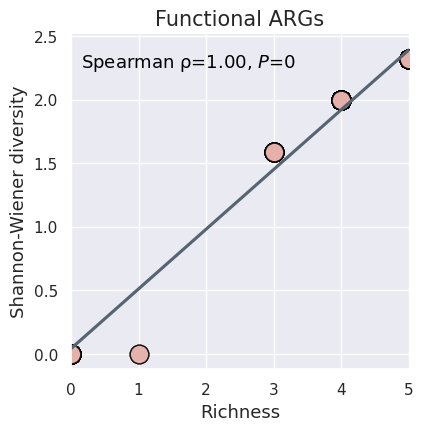

In [81]:
arg_div = pd.read_csv(out_path + "ARG_functional_diversity.csv", index_col=0)

ax = sns.lmplot(
    x="richness",
    y="shannon",
    data=arg_div,
    scatter_kws={"s": 180, "color": "#E6B0AA", "edgecolor": "black"},
    line_kws={"color": "#566573"},
    legend=False,
    height=4.2,
    aspect=1.2,
)
ax.fig.suptitle("", size=15, fontweight="bold", style="italic")
r, p = stats.spearmanr(list(arg_div["richness"]), list(arg_div["shannon"]))
print(r, p)
g = plt.gca()
g.text(
    0.03,
    0.9,
    "Spearman ρ={:.2f}, $P$={:.2g}".format(r, p),
    transform=g.transAxes,
    fontsize=13,
    color="black",
)

ax.fig.set_size_inches(4, 4)

plt.xlabel("Richness", size=13)
plt.ylabel("Shannon-Wiener diversity", size=13)
plt.title("Functional ARGs", size=15)

plt.savefig(out_path + "shannon_rich_corr.pdf", bbox_inches="tight", dpi=300)
plt.show()